In [2]:
!pip install pandas scikit-learn
!pip install imbalanced-learn
!pip install xgboost
!pip install openpyxl

import pandas as pd
from sklearn.preprocessing import StandardScaler # keeping this just in case we decide to experiment with it
import requests
import os
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_recall_curve, make_scorer, f1_score, roc_auc_score, average_precision_score
)
from scipy.stats import gaussian_kde
from joblib import Parallel, delayed  # For parallel processing - keeping this just in case we decide to experiment with it
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
import base64

with open("flow.png", "rb") as img_file:
    encoded_string = base64.b64encode(img_file.read()).decode("utf-8")

print(encoded_string)

iVBORw0KGgoAAAANSUhEUgAACHIAAAQICAYAAABr6G6MAAAKs2lDQ1BJQ0MgUHJvZmlsZQAASImVlwdYE9kWgO9MekhogVCkhBqKIJ0AUkJooQjSwUZIAgRCiIHQREVkcQXWgooI2NBVEQXXAshiw4KFRbFhXxBRUNfFgqiovAl8hN1933vve2e+k/PPybnnnnu/ufOdAYCswxGLhbAyAOmiLEm4vzctNi6ehhsCJKCEXDDQ5nAzxcywsGCAyLT9u3y8CyCZvWUly/Xv//9XUeHxM7kAQGEIJ/IyuekIH0f0I1csyQIAdQjxG+VkiWV8A2E1CVIgws9knDzFn2ScOMlo0mRMZDgLYRoAeBKHI0kGgDQb8dOyuclIHpJsDTYinkCEcAHCHunpGTyE2xE2Q2LECMvyMxL/kif5bzkT5Tk5nGQ5T61lUvA+gkyxkJP3f27H/5Z0oXR6DjqipBRJQDhiVZE9e5aWESRnUeK80GkW8CbjJzlFGhA1zdxMVvw0Zwoj2NPM4/gEyfMI5wVPc5LATx4jyGJHTjM/0zdimiUZ4fJ5kyQs5jRzJDM1SNOi5P4UPluePz8lMmaaswXR8+S1pUUEzcSw5H6JNFy+Fr7I33tmXj/5PqRn/mXtArZ8bFZKZIB8Hzgz9fNFzJmcmbHy2nh8H9+ZmCh5vDjLWz6XWBgmj+cL/eX+zOwI+dgs5OGcGRsm38NUTmDYNAMWyABCRCWABoKROx8Asvi5WbKFsDLEeRJBckoWjYmcNj6NLeJaz6bZ2dg5ACA7u1OPxnvq5JmEqFdnfKsNAHDPm5iYaJ/xBSFn6tgpAIgPZnz0QQAUrwJweStXKsme8qFlPxhARN4JakAL6AEjYAasgB1wAm7AC/iCQBAKIkEcWAy4IAWkI5XngAKwCpSAMrABbAHVYCfYAw6Aw+AoaAHt4By4BK6BG+AOeAj6wCB4BUbARzAOQRAOIkMUSAvSh0wgS8gOYkAekC8UDIVDcVAC

# Table of Contents

1. [Data Source, Project Motivation and Finalized Research Question](#data-source-project-motivation-and-finalized-research-question)
   - [Research Question](#research-question)
   - [Why Random Forest (RF) instead of Support Vector Machine (SVM)?](#why-random-forest-rf-instead-of-support-vector-machine-svm)
   - [Modeling Workflow](#modeling-workflow)
2. [Loading the data](#loading-the-data)
3. [Simple exploration of raw dataset and processing steps](#simple-exploration-of-raw-dataset-and-processing-steps)
   - [First few rows](#first-few-rows)
   - [First few rows after creating a unique identifier "Gene_Probe" can be seen below.](#first-few-rows-after-creating-a-unique-identifier-gene_probe-can-be-seen-below)
   - [Number of rows](#number-of-rows)
   - [Number of columns (features)](#number-of-columns-features)
   - [Determining number of unique samples](#determining-number-of-unique-samples)
   - [Creating a dictionary where each key-value pair represents the count of each unique subtype](#creating-a-dictionary-where-each-key-value-pair-represents-the-count-of-each-unique-subtype)
4. [Data cleaning and refining](#data-cleaning-and-refining)
   - [Reminding ourselves of what we are working with](#reminding-ourselves-of-what-we-are-working-with)
   - [Transposing the dataframe](#transposing-the-dataframe)
   - [As our goal is to identify disease vs healthy state, we are extracting the third item from the sample name and using that to create a "label" column](#as-our-goal-is-to-identify-disease-vs-healthy-state-we-are-extracting-the-third-item-from-the-sample-name-and-using-that-to-create-a-label-column)
5. [Creating final predictor feature - the "disease" column](#creating-final-predictor-feature---the-disease-column)
   - ['disease' column from 'label' column](#disease-column-from-label-column)
   - [Example of 2 rows representing one real sample:](#example-of-2-rows-representing-one-real-sample)
   - [Reminding us what a set of duplicate rows looked like before:](#reminding-us-what-a-set-of-duplicate-rows-looked-like-before)
   - [Now only one row represents the one sample - we took the average across the 2 rows for the numeric columns](#now-only-one-row-represents-the-one-sample---we-took-the-average-across-the-2-rows-for-the-numeric-columns)
   - [WE WANT THIS TO PRODUCE AN ERROR! The below shows that the replicate row no longer exists in our dataframe](#we-want-this-to-produce-an-error-the-below-shows-that-the-replicate-row-no-longer-exists-in-our-dataframe)
6. [Shape of data after refining](#shape-of-data-after-refining)
7. [Class imbalance](#class-imbalance)
8. [Missing Values - none!](#missing-values---none)
9. [Models Overview](#models-overview)
10. [Baseline RF model](#baseline-rf-model)
   - [Some technical details about baseline RF:](#some-technical-details-about-baseline-rf)
11. [Top 5 "most predictive" genes according to this RF model (simply derived from RF for visualization purposes only!)](#top-5-most-predictive-genes-according-to-this-rf-model-simply-derived-from-rf-for-visualization-purposes-only)
12. [Improving the baseline... what happens to Precision-Recall AUC if we train an RF model with just these 5 predictors?](#improving-the-baseline-what-happens-to-precision-recall-auc-if-we-train-an-rf-model-with-just-these-5-predictors)
    - [Some technical details about improving baseline RF:](#some-technical-details-about-improving-baseline-rf)
13. [Boxplot Visualization & Outliers](#boxplot-visualization--outliers)
14. [Histogram Visualization & Distribution](#histogram-visualization--distribution)
15. [Heatmap](#heatmap)
16. [Clustering Plot](#clustering-plot)
17. [RFE 1: The best genes (predictors) that were selected by the RF-based RFE process](#rfe-1-the-best-genes-predictors-that-were-selected-by-the-rf-based-rfe-process)
    - [Some technical details about RF-based RFE:](#some-technical-details-about-rf-based-rfe)
18. [Random Forest - trained with RFE 1 (predictors identified from RF-based RFE process)](#random-forest---trained-with-rfe-1-predictors-identified-from-rf-based-rfe-process)
    - [Some technical details about this model using RF-based RFE-derived predictors:](#some-technical-details-about-this-model-using-rf-based-rfe-derived-predictors)
19. [RFE 2: The best genes (predictors) that were selected by the XGBoost-based RFE process](#rfe-2-the-best-genes-predictors-that-were-selected-by-the-xgboost-based-rfe-process)
    - [Some technical details about XGBoost-based RFE:](#some-technical-details-about-this-model-using-xgboost-based-rfe-derived-predictors)
20. [XGBoost - trained with RFE 2 (predictors identified from XGBoost-based RFE process)](#xgboost---trained-with-rfe-2-predictors-identified-from-xgboost-based-rfe-process)
    - [Some technical details about this model also using XGBoost-based RFE-derived predictors:](#some-technical-details-about-this-model-also-using-xgboost-based-rfe-derived-predictors)
21. [Inference](#inference)
    - [Getting a ranked list `sorted_importances` of feature importances for this `best_model`](#getting-a-ranked-list-sorted_importances-of-feature-importances-for-this-best_model)
    - [Printing overlaid histograms for the top 25 most important genes for this model](#printing-overlaid-histograms-for-the-top-25-most-important-genes-for-this-model)
    - [Dendogram of the top 25 genes identified](#dendogram-of-the-top-25-genes-identified)

# Data Source, Project Motivation and Finalized Research Question

We looked at a highly-dimensional dataset showing the degree to which ~28246 genes are expressed in 408 sample analyses, including a few replicate analyses of certain samples for validation - these represent samples that were collected from 115 endometriosis patients and 53 healthy controls. Our goal is to explore feature importance, with the hope of better understanding which genes are most important for predicting endometriosis, a chronic disease which affects ~10% of women worldwide and has no cure. Endometriosis is a poorly understood disease that is characterized by uterine tissue cells growing outside of the uterus, which can be debilitating and fertility-impacting; in many cases, multiple surgeries (sometimes the complete removal of a uterus) is required for managing this condition. A better understanding of differences between gene expression in healthy controls vs endometriosis patients can offer insight into potential drug targets and new therapeutics. In hopes to facilitate more research on endometriosis, researchers at the University of Turku in Finland created a dataset with more than 392 unique samples, documenting the expression of thousands of genes in each sample, as outlined above. Note that some patients contributed multiple unique samples. The final output of the Turku-led project was a user interface for assisting researchers. However, we were able to collect their raw data, which they claim was normalized, but the scale makes us believe it was likely standardized. The data was also batch-controlled, meaning that the research team accounted for technical differences arising from the use of different machines for analyzing samples - this way, we are capturing biological differences, as opposed to technical measurement differences. This raw data leaves a treasure trove of questions to be asked and potentially answered, thus motivating our finalized research question: 

#### Research Question
**Can we maintain or improve endometriosis prediction accuracy using Random Forest or XGBoost after drastically reducing features from over 28k genes to a small, most-predictive subset - and what does this subset reveal about the disease?**

#### Why Random Forest (RF) instead of Support Vector Machine (SVM)?
While we considered building an SVM model, which can be used find decision boundaries in complex datasets, we ultimately decided to create an RF model instead. RF models appear to be a better choice than SVM for highly dimensional datasets with severe class imbalance (15% minority class in our case), because it handles class imbalance more effectively - RF manages this by generating class probabilities and allowing adjustment of weights or thresholds to focus on the minority class. RF's ensemble approach naturally captures patterns from the minority class, offers built-in feature selection to mitigate noise in high-dimensional data, and provides interpretable insights through feature importance scores, which are relevant parts for our project, given our key objective of understanding how and which gene expressions are related to endometriosis. Additionally, RF is more computationally efficient (and robust to outliers) compared to SVM, which struggles with class imbalance and requires more extensive hyperparameter tuning. The highly-dimensional nature of our dataset further raises concerns about SVM being prone to overfitting or computational inefficient. Due to these reasons, RF appears to be a more practical and reliable option for predicting endometriosis in our context.

#### Why XGBoost?
**Spoiler alert!** XGBoost not only uses gradient-boosting techniques to iteratively refine its decision boundaries - it also proves highly adaptable to our class-imbalanced scenarios. In our case, the XGBoost-based RFE approach led to a final model that outperformed the RF-based methods in terms of macro average F1 score (our primary metric of interest - more on this soon!) despite drastically reducing the original feature set (from over 28k genes down to just 329). Importantly, it achieved this improvement by notably increasing the recall for the minority class (healthy samples), demonstrating that targeted feature selection combined with XGBoost's robust, iterative refinement can give a more balanced, clinically meaningful predictive performance for endometriosis classification.

#### Modeling Workflow
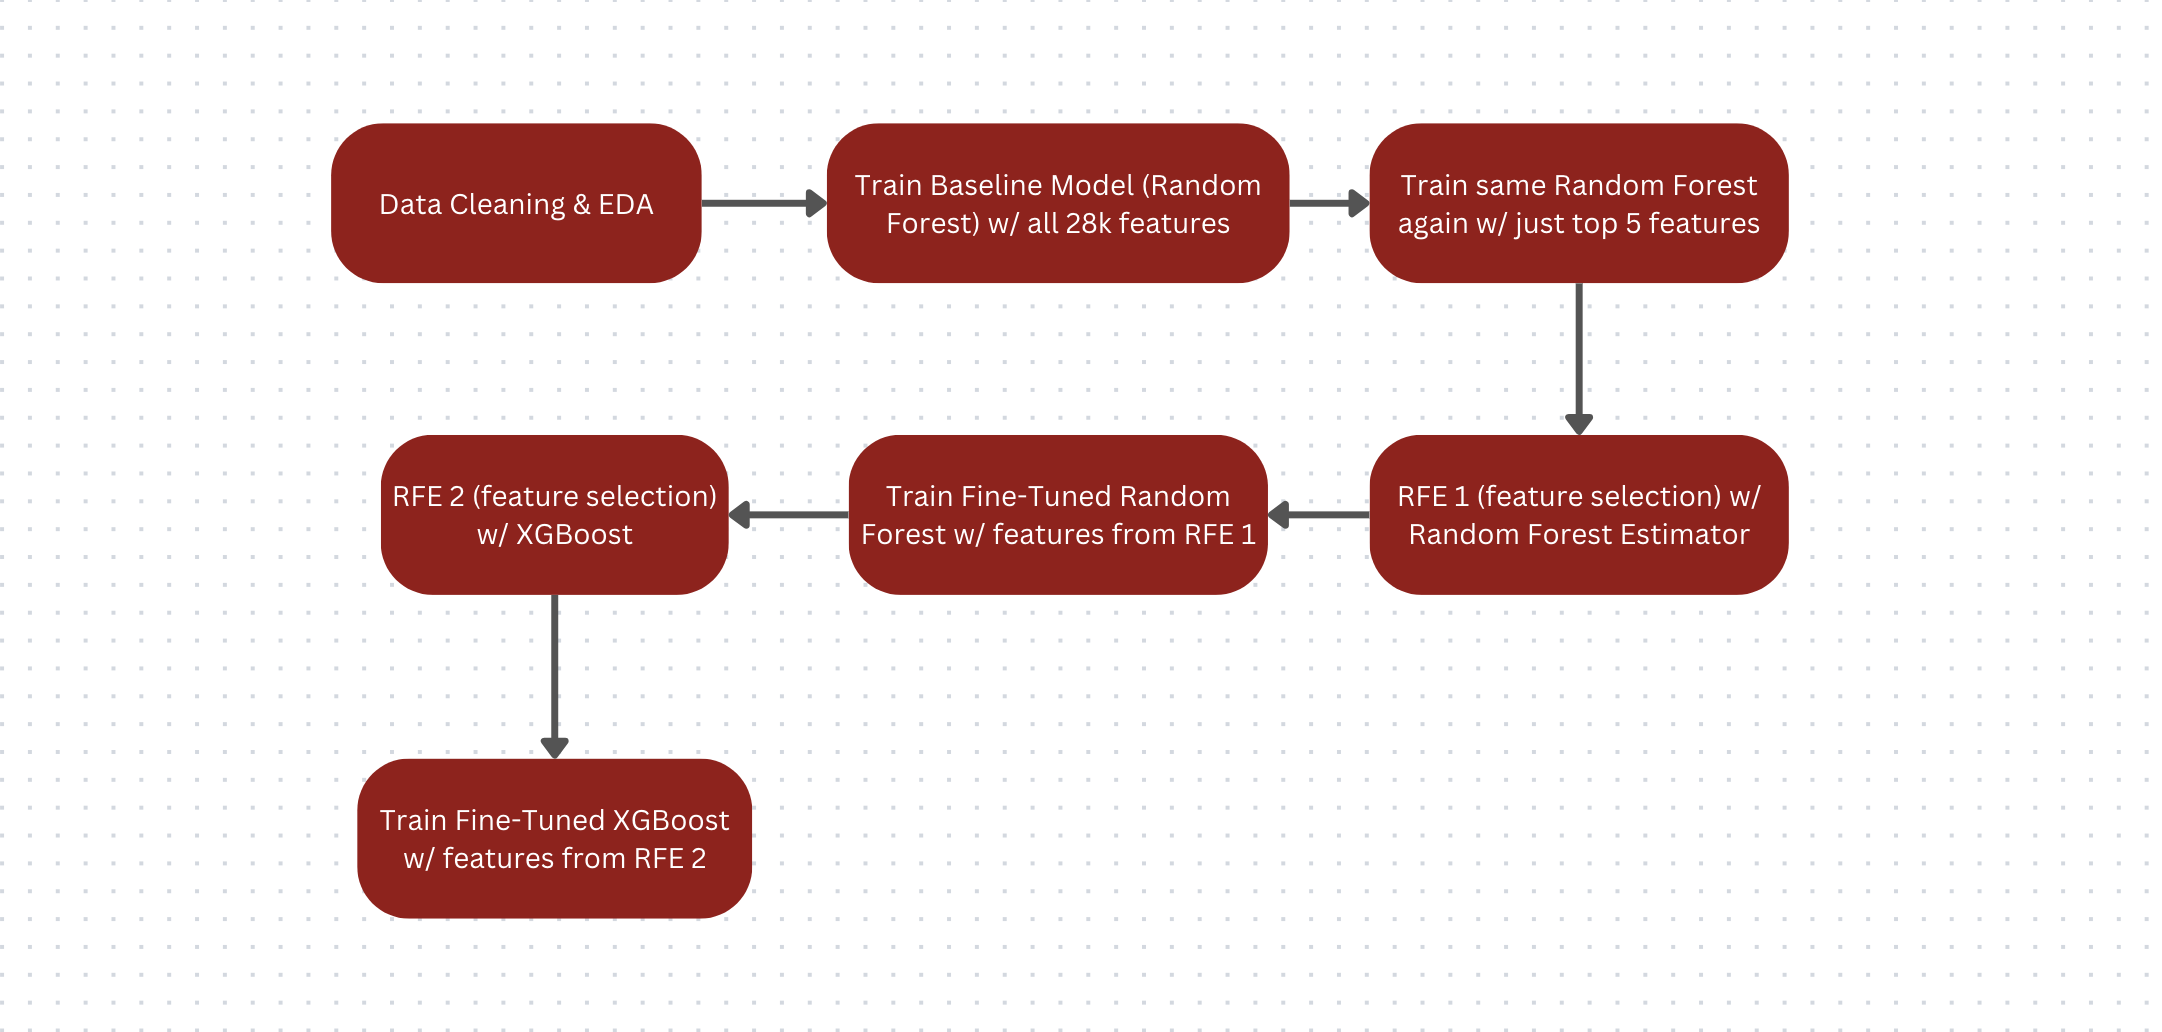

# Loading the data

In [2]:
filePath = "content/GSE141549_batchCorrectednormalizedArrayscombined.xlsx"

# URL for downloading the file
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE141549&format=file&file=GSE141549%5FbatchCorrectednormalizedArrayscombined%2Exlsx"

# checking if the file already exists
if not os.path.exists(filePath):
    os.makedirs(os.path.dirname(filePath), exist_ok=True)
    # Download the file if it doesn't exist
    response = requests.get(url)
    with open(filePath, "wb") as file:
        file.write(response.content)
    print("File downloaded.")
else:
    print("File already exists.")

# loading the Excel file into a pandas DataFrame
df = pd.read_excel(filePath)
print("Data loaded successfully.")

File already exists.
Data loaded successfully.


# Simple exploration of raw dataset and processing steps

### First few rows

In [3]:
df.head(4)

,Gene_symbol,Probe_Id,SAMPLE 332 PE,SAMPLE 333 DiEIn,SAMPLE 334 PE,SAMPLE 335 PeLB,SAMPLE 336 PE,SAMPLE 337 PE,SAMPLE 338 PP,SAMPLE 339 SuL,...,SAMPLE 26 CE,SAMPLE 27 PE,SAMPLE 28 REV,SAMPLE 29 PeLR,SAMPLE 30 OMA,SAMPLE 31 CP,SAMPLE 32 CE,SAMPLE 33 PE,SAMPLE 34 PP,SAMPLE 35 PeLR
0,RERE,ILMN_1802380,11.488459,11.605685,12.006795,12.132273,11.416302,12.186470,11.340178,12.025644,...,11.693660,11.160831,11.869227,11.434205,11.010967,11.847268,11.309100,11.839674,11.765684,11.533947
1,LOC105374121,ILMN_1736104,6.673564,6.520175,6.619677,6.514652,6.602206,6.596461,6.805189,6.483506,...,6.597478,6.580707,6.653111,6.552827,6.587035,6.531963,6.592075,6.423123,6.499188,6.732907
2,CIDEA,ILMN_1788184,6.680433,6.588961,6.593340,7.795417,6.598428,6.666354,8.203924,6.661223,...,6.991229,6.916313,7.031737,6.982656,6.649744,6.665928,6.834289,6.915713,6.365116,7.105330
3,SLC17A3,ILMN_1690979,6.772489,6.482288,6.579807,6.409611,6.361172,6.496526,6.489509,6.617248,...,6.384578,6.471227,6.203973,6.407872,6.334447,6.402750,6.371500,6.407001,6.417949,6.386594


In [4]:
df["Gene_Probe"] = df["Gene_symbol"] + '_' + df["Probe_Id"]
df = df.set_index("Gene_Probe") #setting it as our identifier
df = df.drop(columns=["Gene_symbol", "Probe_Id"]) #no longer needed

### First few rows after creating a unique identifier "Gene_Probe" can be seen below. 
Please note that currently, the rows below represent genes, but since we will be using that to predict the disease/health status, we will be transposing this df momentarily.

In [5]:
df.head(4)

,SAMPLE 332 PE,SAMPLE 333 DiEIn,SAMPLE 334 PE,SAMPLE 335 PeLB,SAMPLE 336 PE,SAMPLE 337 PE,SAMPLE 338 PP,SAMPLE 339 SuL,SAMPLE 340 PE,SAMPLE 341 PP,...,SAMPLE 26 CE,SAMPLE 27 PE,SAMPLE 28 REV,SAMPLE 29 PeLR,SAMPLE 30 OMA,SAMPLE 31 CP,SAMPLE 32 CE,SAMPLE 33 PE,SAMPLE 34 PP,SAMPLE 35 PeLR
Gene_Probe,,,,,,,,,,,,,,,,,,,,,
RERE_ILMN_1802380,11.488459,11.605685,12.006795,12.132273,11.416302,12.186470,11.340178,12.025644,11.613111,12.006795,...,11.693660,11.160831,11.869227,11.434205,11.010967,11.847268,11.309100,11.839674,11.765684,11.533947
LOC105374121_ILMN_1736104,6.673564,6.520175,6.619677,6.514652,6.602206,6.596461,6.805189,6.483506,6.701358,6.707116,...,6.597478,6.580707,6.653111,6.552827,6.587035,6.531963,6.592075,6.423123,6.499188,6.732907
CIDEA_ILMN_1788184,6.680433,6.588961,6.593340,7.795417,6.598428,6.666354,8.203924,6.661223,6.551393,8.027454,...,6.991229,6.916313,7.031737,6.982656,6.649744,6.665928,6.834289,6.915713,6.365116,7.105330
SLC17A3_ILMN_1690979,6.772489,6.482288,6.579807,6.409611,6.361172,6.496526,6.489509,6.617248,6.427462,6.481086,...,6.384578,6.471227,6.203973,6.407872,6.334447,6.402750,6.371500,6.407001,6.417949,6.386594


### Number of rows
We have not yet transposed the df, so we get the number of rows by looking at the number of columns

In [6]:
len(df.columns) # number of samples, though some are replicates because the researchers wanted to ensure the results were correct

408

### Number of columns (features)
We have not yet transposed the df, so we get the number of columns by looking at the number of rows

In [7]:
len(df) # number of unique genes+probe

28247

### Determining number of unique samples
We create a list of all the column names (which represent each future row after we transpose the df). The goal is to get a sense of how many samples were analyzed more than once, i.e. the number of replicates.

In [8]:
columnNames = [col for col in df.columns if col not in ["", "Gene_symbol", "Probe_Id"]]
print(f"Number of sample analyses: {len(columnNames)}")
# Defining a function to extract the numerical part from the column name
def extractSampleNumber(columnNameInput):
    # Split by spaces and take the second part, which should be the number
    parts = columnNameInput.split(" ")
    if len(parts) > 1 and parts[1].isdigit():
        return int(parts[1])
    return float("inf")  # In case the format is unexpected

# Sorting the column names using the custom function
sortedColumns = sorted(columnNames, key=extractSampleNumber)

# displaying the first few sorted column names
sortedColumns[:7]


Number of sample analyses: 408


['SAMPLE 1 OMA',
 'SAMPLE 2 PP',
 'SAMPLE 3 PE',
 'SAMPLE 4 DiEIn',
 'SAMPLE 5 REV',
 'SAMPLE 6 CP',
 'SAMPLE 7 PP']

In [9]:
totalItems = len(sortedColumns)
replicateItems = sum(1 for item in sortedColumns if item.endswith("Replicate"))
uniqueRows = totalItems - replicateItems
print(f"Total items in sortedColumns: {totalItems}")
print(f"Total items ending with 'Replicate': {replicateItems}")
print(f"Total unique samples: {uniqueRows}")

Total items in sortedColumns: 408
Total items ending with 'Replicate': 16
Total unique samples: 392


### Creating a dictionary where each key-value pair represents the count of each unique subtype
We are extracting the third item from each column name (as this code indicates type of disease state or healthy state), then we are creating a dictionary showing the number of samples with the various endometriosis classifications!

In [10]:
# extracting the codes from the column (3rd item) that we could predict with our ensamble model
codes = [item.split()[2] for item in sortedColumns if len(item.split()) >= 3]

# creating a dictionary with the count of each unique code -> data imbalance?
codeCounts = Counter(codes)

# print the dict
print(codeCounts)

Counter({'PE': 104, 'CE': 43, 'PP': 39, 'DiEIn': 39, 'PeLB': 29, 'OMA': 28, 'PeLR': 28, 'SuL': 27, 'CP': 24, 'REV': 22, 'PeLW': 22, 'DiEB': 3})



> ***Each of these codes represent either a disease-type or healthy state, and it is this dicotomy that we will be predicting with an ensamble model. The input will be a new sample containing gene expression data (each feature will be the level of expression for a specific gene) and we will be predicting if it represents a diseased or healthy sample:***

**The following codes appear to correspond to healthy controls based on the original scientific paper published by the Turku researchers:**
- CP: peritoneum samples from healthy control
- CE: endometrium sample from healthty control

**The rest of the codes seen to represent various types of endometriosis subtypes from endometriosis patients:**

- PeLR: red peritoneal endometriotic lesion
- DiEIn: intestinal endometriotic lesions
- PeLW: white peritoneal endometriotic lesion
- REV: deep rectovaginal endometriotic lesions
- DiEB: deep endometriotic lesions in the bladder
- PE: endometrium sample from endometriosis patient
- SuL: sacrouterine ligament endometriotic lesions
- PeLB: black peritoneal endometriotic lesion
- OMA: ovarian endometrioma samples
- PP: peritoneum samples from patients

# Data cleaning and refining

### Reminding ourselves of what we are working with

In [11]:
print(len(df.columns)) # number of sample analysis outputs, though some are replicates of one sample because the researchers wanted to ensure the results were correct
print(len(df)) # number of unique genes+probe
df.head(4)

408
28247


,SAMPLE 332 PE,SAMPLE 333 DiEIn,SAMPLE 334 PE,SAMPLE 335 PeLB,SAMPLE 336 PE,SAMPLE 337 PE,SAMPLE 338 PP,SAMPLE 339 SuL,SAMPLE 340 PE,SAMPLE 341 PP,...,SAMPLE 26 CE,SAMPLE 27 PE,SAMPLE 28 REV,SAMPLE 29 PeLR,SAMPLE 30 OMA,SAMPLE 31 CP,SAMPLE 32 CE,SAMPLE 33 PE,SAMPLE 34 PP,SAMPLE 35 PeLR
Gene_Probe,,,,,,,,,,,,,,,,,,,,,
RERE_ILMN_1802380,11.488459,11.605685,12.006795,12.132273,11.416302,12.186470,11.340178,12.025644,11.613111,12.006795,...,11.693660,11.160831,11.869227,11.434205,11.010967,11.847268,11.309100,11.839674,11.765684,11.533947
LOC105374121_ILMN_1736104,6.673564,6.520175,6.619677,6.514652,6.602206,6.596461,6.805189,6.483506,6.701358,6.707116,...,6.597478,6.580707,6.653111,6.552827,6.587035,6.531963,6.592075,6.423123,6.499188,6.732907
CIDEA_ILMN_1788184,6.680433,6.588961,6.593340,7.795417,6.598428,6.666354,8.203924,6.661223,6.551393,8.027454,...,6.991229,6.916313,7.031737,6.982656,6.649744,6.665928,6.834289,6.915713,6.365116,7.105330
SLC17A3_ILMN_1690979,6.772489,6.482288,6.579807,6.409611,6.361172,6.496526,6.489509,6.617248,6.427462,6.481086,...,6.384578,6.471227,6.203973,6.407872,6.334447,6.402750,6.371500,6.407001,6.417949,6.386594


### Transposing the dataframe
Next, we are transposing the dataframe, as our goal is to use the genes (currently rows) as our predictors, hence their transformation into columns - the "Gene_Probe" column name above the samples will be removed momentarily

In [12]:
transposedDF = df.T
print(f"Number of total columns: {len(transposedDF.columns)}")
print(f"Number of total rows: {len(transposedDF)}")
transposedDF.head(4)

Number of total columns: 28247
Number of total rows: 408


Gene_Probe,RERE_ILMN_1802380,LOC105374121_ILMN_1736104,CIDEA_ILMN_1788184,SLC17A3_ILMN_1690979,ATP6V1C2_ILMN_1660729,ZNF768_ILMN_1791820,F3_ILMN_2129572,HTR5BP_ILMN_1858692,LINC00999_ILMN_3239930,GAK_ILMN_1701042,...,ZSCAN26_ILMN_1651905,ZSCAN4_ILMN_1725718,ZSWIM3_ILMN_1684960,ZSWIM8_ILMN_1669433,ZWINT_ILMN_1673117,ZXDA_ILMN_1713868,ZYG11A_ILMN_1794932,ZYG11A_ILMN_1723439,ZYX_ILMN_1701875,ZZZ3_ILMN_1653618
SAMPLE 332 PE,11.488459,6.673564,6.680433,6.772489,6.806118,8.939555,7.705613,6.400467,6.705788,6.240199,...,6.724087,6.522196,6.625318,11.105910,6.725321,6.671754,6.341979,6.378403,12.169301,9.622711
SAMPLE 333 DiEIn,11.605685,6.520175,6.588961,6.482288,6.547302,8.331163,7.857551,6.347822,7.049031,6.291638,...,6.721231,6.492125,6.381971,11.156876,6.660244,6.555477,6.308850,6.476137,12.272535,9.737564
SAMPLE 334 PE,12.006795,6.619677,6.593340,6.579807,8.239626,8.742562,7.932845,6.487091,6.981085,6.361566,...,6.636470,6.601727,6.730844,11.737975,6.470417,6.379294,6.415222,6.368305,12.264406,9.515193
SAMPLE 335 PeLB,12.132273,6.514652,7.795417,6.409611,6.805541,8.385348,7.863452,6.454700,6.936864,6.228683,...,6.847214,7.449695,6.600583,11.560674,6.665999,6.488463,6.457537,6.424394,11.910975,9.353855


### As our goal is to identify disease vs healthy state, we are extracting the third item from the sample name and using that to create a "label" column

In [13]:
# adding a new "label" column by extracting the third item from the row index (sample name)
transposedDF.insert(0, "label", transposedDF.index.str.split().str[2])
print(f"Number of total columns: {len(transposedDF.columns)}")
print(f"Number of total rows: {len(transposedDF)}")
# showing the first few rows to verify
transposedDF.head(4)

Number of total columns: 28248
Number of total rows: 408


Gene_Probe,label,RERE_ILMN_1802380,LOC105374121_ILMN_1736104,CIDEA_ILMN_1788184,SLC17A3_ILMN_1690979,ATP6V1C2_ILMN_1660729,ZNF768_ILMN_1791820,F3_ILMN_2129572,HTR5BP_ILMN_1858692,LINC00999_ILMN_3239930,...,ZSCAN26_ILMN_1651905,ZSCAN4_ILMN_1725718,ZSWIM3_ILMN_1684960,ZSWIM8_ILMN_1669433,ZWINT_ILMN_1673117,ZXDA_ILMN_1713868,ZYG11A_ILMN_1794932,ZYG11A_ILMN_1723439,ZYX_ILMN_1701875,ZZZ3_ILMN_1653618
SAMPLE 332 PE,PE,11.488459,6.673564,6.680433,6.772489,6.806118,8.939555,7.705613,6.400467,6.705788,...,6.724087,6.522196,6.625318,11.105910,6.725321,6.671754,6.341979,6.378403,12.169301,9.622711
SAMPLE 333 DiEIn,DiEIn,11.605685,6.520175,6.588961,6.482288,6.547302,8.331163,7.857551,6.347822,7.049031,...,6.721231,6.492125,6.381971,11.156876,6.660244,6.555477,6.308850,6.476137,12.272535,9.737564
SAMPLE 334 PE,PE,12.006795,6.619677,6.593340,6.579807,8.239626,8.742562,7.932845,6.487091,6.981085,...,6.636470,6.601727,6.730844,11.737975,6.470417,6.379294,6.415222,6.368305,12.264406,9.515193
SAMPLE 335 PeLB,PeLB,12.132273,6.514652,7.795417,6.409611,6.805541,8.385348,7.863452,6.454700,6.936864,...,6.847214,7.449695,6.600583,11.560674,6.665999,6.488463,6.457537,6.424394,11.910975,9.353855


# Creating final predictor feature - the "disease" column

### 'disease' column from 'label' column
Now that we have the label column, we can use this column to indicate if the respective row represents a diseased or healthy state under a new column "disease", which is what our trained model will be predicting

In [14]:
# creating a "disease" column with 0 if label is "CP" or "CE", otherwise 1 (as all other codes represents disease)
transposedDF.insert(1, "disease", transposedDF["label"].apply(lambda x: 0 if x in ["CP", "CE"] else 1))
transposedDF.sort_index(ascending=True)
print(f"Number of total columns: {len(transposedDF.columns)}")
print(f"Number of total rows: {len(transposedDF)}")
# showing the first few rows to verify
transposedDF.head(4)

Number of total columns: 28249
Number of total rows: 408


Gene_Probe,label,disease,RERE_ILMN_1802380,LOC105374121_ILMN_1736104,CIDEA_ILMN_1788184,SLC17A3_ILMN_1690979,ATP6V1C2_ILMN_1660729,ZNF768_ILMN_1791820,F3_ILMN_2129572,HTR5BP_ILMN_1858692,...,ZSCAN26_ILMN_1651905,ZSCAN4_ILMN_1725718,ZSWIM3_ILMN_1684960,ZSWIM8_ILMN_1669433,ZWINT_ILMN_1673117,ZXDA_ILMN_1713868,ZYG11A_ILMN_1794932,ZYG11A_ILMN_1723439,ZYX_ILMN_1701875,ZZZ3_ILMN_1653618
SAMPLE 332 PE,PE,1,11.488459,6.673564,6.680433,6.772489,6.806118,8.939555,7.705613,6.400467,...,6.724087,6.522196,6.625318,11.105910,6.725321,6.671754,6.341979,6.378403,12.169301,9.622711
SAMPLE 333 DiEIn,DiEIn,1,11.605685,6.520175,6.588961,6.482288,6.547302,8.331163,7.857551,6.347822,...,6.721231,6.492125,6.381971,11.156876,6.660244,6.555477,6.308850,6.476137,12.272535,9.737564
SAMPLE 334 PE,PE,1,12.006795,6.619677,6.593340,6.579807,8.239626,8.742562,7.932845,6.487091,...,6.636470,6.601727,6.730844,11.737975,6.470417,6.379294,6.415222,6.368305,12.264406,9.515193
SAMPLE 335 PeLB,PeLB,1,12.132273,6.514652,7.795417,6.409611,6.805541,8.385348,7.863452,6.454700,...,6.847214,7.449695,6.600583,11.560674,6.665999,6.488463,6.457537,6.424394,11.910975,9.353855


### Example of 2 rows representing one real sample:

In [15]:
rowsOriginal = transposedDF.loc[['SAMPLE 121 CE', 'SAMPLE 121 CE Replicate']]
rowsOriginal

Gene_Probe,label,disease,RERE_ILMN_1802380,LOC105374121_ILMN_1736104,CIDEA_ILMN_1788184,SLC17A3_ILMN_1690979,ATP6V1C2_ILMN_1660729,ZNF768_ILMN_1791820,F3_ILMN_2129572,HTR5BP_ILMN_1858692,...,ZSCAN26_ILMN_1651905,ZSCAN4_ILMN_1725718,ZSWIM3_ILMN_1684960,ZSWIM8_ILMN_1669433,ZWINT_ILMN_1673117,ZXDA_ILMN_1713868,ZYG11A_ILMN_1794932,ZYG11A_ILMN_1723439,ZYX_ILMN_1701875,ZZZ3_ILMN_1653618
SAMPLE 121 CE,CE,0,10.615320,6.679381,7.069106,6.547775,8.287285,8.444118,9.618014,6.322037,...,6.613581,6.41857,7.116290,10.325763,6.558989,6.363129,6.560848,6.422209,12.821027,9.558652
SAMPLE 121 CE Replicate,CE,0,10.833608,6.722729,6.315895,6.432962,7.558600,8.658778,8.893812,6.427485,...,6.724493,6.33651,6.358608,10.633035,6.662112,6.378342,6.564570,6.368253,11.555183,9.757919


In [16]:
allSamples = sorted(transposedDF.index.tolist())
allSamples[:7]

['SAMPLE 1 OMA',
 'SAMPLE 10 OMA',
 'SAMPLE 100 PeLR',
 'SAMPLE 101 PP',
 'SAMPLE 102 DiEIn',
 'SAMPLE 103 PeLW',
 'SAMPLE 104 PE']

In [17]:
# Step 1: Reset the index and ensure the index column has a name
transposedDF = transposedDF.reset_index()

# Rename the index column if it's unnamed or named differently
if transposedDF.columns[0] != 'Gene_Probe':
    transposedDF = transposedDF.rename(columns={transposedDF.columns[0]: 'Gene_Probe'})

# Step 2: Remove ' Replicate' from 'Gene_Probe' to create base names
transposedDF['Gene_Probe'] = transposedDF['Gene_Probe'].str.replace(' Replicate$', '', regex=True)

# Step 3: Identify data columns (excluding 'Gene_Probe', 'label', 'disease')
data_cols = transposedDF.columns.difference(['Gene_Probe', 'label', 'disease'])

# Step 4: Define aggregation functions
aggregations = {col: 'mean' for col in data_cols}
aggregations.update({'label': 'first', 'disease': 'first'})

# Store the original columns before grouping
original_columns = transposedDF.columns

# Step 5: Group by 'Gene_Probe' and aggregate
transposedDF = transposedDF.groupby('Gene_Probe', as_index=False).agg(aggregations)

# Step 6: Set 'Gene_Probe' back as the index (if required)
transposedDF = transposedDF.set_index('Gene_Probe')

# Step 7: Reorder the columns to match the original order
transposedDF = transposedDF[original_columns.difference(['Gene_Probe'])]  # Remove 'Gene_Probe' as it's the index
transposedDF = transposedDF.reset_index()  # Re-add 'Gene_Probe' for ordering
transposedDF = transposedDF[original_columns]  # Order columns exactly as in the original
transposedDF = transposedDF.set_index('Gene_Probe')  # Set 'Gene_Probe' back as the index if needed

# Display the first 4 rows
transposedDF.head(4)

Gene_Probe,label,disease,RERE_ILMN_1802380,LOC105374121_ILMN_1736104,CIDEA_ILMN_1788184,SLC17A3_ILMN_1690979,ATP6V1C2_ILMN_1660729,ZNF768_ILMN_1791820,F3_ILMN_2129572,HTR5BP_ILMN_1858692,...,ZSCAN26_ILMN_1651905,ZSCAN4_ILMN_1725718,ZSWIM3_ILMN_1684960,ZSWIM8_ILMN_1669433,ZWINT_ILMN_1673117,ZXDA_ILMN_1713868,ZYG11A_ILMN_1794932,ZYG11A_ILMN_1723439,ZYX_ILMN_1701875,ZZZ3_ILMN_1653618
Gene_Probe,,,,,,,,,,,,,,,,,,,,,
SAMPLE 1 OMA,OMA,1,11.449473,6.536105,7.542748,6.438908,6.484894,8.762321,8.017512,6.269659,...,6.668651,6.646208,6.395408,11.444387,6.398342,6.517778,6.363869,6.245223,11.967503,9.494950
SAMPLE 10 OMA,OMA,1,11.661547,6.702027,7.018477,6.409870,8.473473,7.425452,8.959437,6.519406,...,6.630572,6.517468,6.096741,10.647588,6.555686,6.458170,6.306452,6.481059,11.720273,9.595461
SAMPLE 100 PeLR,PeLR,1,12.653095,6.538306,6.540266,6.322736,6.448993,8.177972,8.622699,6.416195,...,6.688430,6.654922,6.334504,11.617943,6.585496,6.491730,6.342675,6.438649,11.875686,9.422292
SAMPLE 101 PP,PP,1,12.166617,6.478355,6.798654,6.423690,6.578178,8.552622,9.233912,6.321077,...,6.496436,6.433557,6.294022,11.580790,6.649865,6.449307,6.383782,6.429199,12.424216,8.633182


### Reminding us what a set of duplicate rows looked like before:

In [18]:
rowsOriginal

Gene_Probe,label,disease,RERE_ILMN_1802380,LOC105374121_ILMN_1736104,CIDEA_ILMN_1788184,SLC17A3_ILMN_1690979,ATP6V1C2_ILMN_1660729,ZNF768_ILMN_1791820,F3_ILMN_2129572,HTR5BP_ILMN_1858692,...,ZSCAN26_ILMN_1651905,ZSCAN4_ILMN_1725718,ZSWIM3_ILMN_1684960,ZSWIM8_ILMN_1669433,ZWINT_ILMN_1673117,ZXDA_ILMN_1713868,ZYG11A_ILMN_1794932,ZYG11A_ILMN_1723439,ZYX_ILMN_1701875,ZZZ3_ILMN_1653618
SAMPLE 121 CE,CE,0,10.615320,6.679381,7.069106,6.547775,8.287285,8.444118,9.618014,6.322037,...,6.613581,6.41857,7.116290,10.325763,6.558989,6.363129,6.560848,6.422209,12.821027,9.558652
SAMPLE 121 CE Replicate,CE,0,10.833608,6.722729,6.315895,6.432962,7.558600,8.658778,8.893812,6.427485,...,6.724493,6.33651,6.358608,10.633035,6.662112,6.378342,6.564570,6.368253,11.555183,9.757919


### Now only one row represents the one sample - we took the average across the 2 rows for the numeric columns

In [19]:
rowsAfter1 = transposedDF.loc[['SAMPLE 121 CE']]
rowsAfter1

Gene_Probe,label,disease,RERE_ILMN_1802380,LOC105374121_ILMN_1736104,CIDEA_ILMN_1788184,SLC17A3_ILMN_1690979,ATP6V1C2_ILMN_1660729,ZNF768_ILMN_1791820,F3_ILMN_2129572,HTR5BP_ILMN_1858692,...,ZSCAN26_ILMN_1651905,ZSCAN4_ILMN_1725718,ZSWIM3_ILMN_1684960,ZSWIM8_ILMN_1669433,ZWINT_ILMN_1673117,ZXDA_ILMN_1713868,ZYG11A_ILMN_1794932,ZYG11A_ILMN_1723439,ZYX_ILMN_1701875,ZZZ3_ILMN_1653618
Gene_Probe,,,,,,,,,,,,,,,,,,,,,
SAMPLE 121 CE,CE,0,10.724464,6.701055,6.6925,6.490369,7.922942,8.551448,9.255913,6.374761,...,6.669037,6.37754,6.737449,10.479399,6.61055,6.370736,6.562709,6.395231,12.188105,9.658286


#### WE WANT THIS TO PRODUCE AN ERROR! The below shows that the replicate row no longer exists in our dataframe
If you uncomment it and run it, it produces an error as intended, suggesting we have removed the replicate entries!

In [20]:
#rowsAfter2 = transposedDF.loc[['SAMPLE 121 CE Replicate']]
#rowsAfter2

# Shape of data after refining

In [21]:
# Get the number of rows and columns
numRows, numColumns = transposedDF.shape

# Display the number of rows and columns
print(f"Number of rows: {numRows}") # minus 2 because the first 2 columns (excluding the index) don't represent a gene/feature
print(f"Number of columns: {numColumns - 3}")

Number of rows: 392
Number of columns: 28246


# Class imbalance

In [22]:
# counting the number of rows with 0 and 1 in the "disease" column
count_0 = (transposedDF["disease"] == 0).sum()
count_1 = (transposedDF["disease"] == 1).sum()

# calculating the total number of rows
total_rows = len(transposedDF["disease"])

# calculating the percentages
percentage_0 = (count_0 / total_rows) * 100
percentage_1 = (count_1 / total_rows) * 100

# printing the counts with percentages
print(f"Samples (rows in transposedDF) from healthy control individuals = 0: {count_0} ({percentage_0:.2f}%)")
print(f"Samples (rows in transposedDF) from endometriosis patients: {count_1} ({percentage_1:.2f}%)")

Samples (rows in transposedDF) from healthy control individuals = 0: 62 (15.82%)
Samples (rows in transposedDF) from endometriosis patients: 330 (84.18%)


> **Class imbalance!** The above code output suggests we are dealing with class imbalance - since there is an imbalance between 0s and 1s in the "disease" column, we can consider using techniques like oversampling the minority class (samples from healthy control individuals)...


# Missing Values - none!

In [23]:
# checking for missing values in the entire DataFrame
missingData = transposedDF.isnull().sum()

# columns with missing values
missingColumns = missingData[missingData > 0]

# summary
if missingColumns.empty:
    print("No missing values found in the dataset.")
else:
    print("Columns with missing values and their counts:")
    print(missingColumns)


No missing values found in the dataset.


# Models Overview
Our analyses looked at the performance of four (4) predictive models, each of which is trained to classify the target variable (disease or healthy) with varying feature sets and methods. Starting with a baseline Random Forest (RF) model, subsequent models explored feature selection and refinement through techniques like recursive feature elimination (RFE), hyperparameter-tuning and comparisons between Random Forest and XGBoost. Due to the class imbalance in our data set, our primary metric to determine the "best" model was the `Test Macro F1 Score` on the test data. We relied on both training and testing classification reports to indicate a models performance on the the minority class.

The results indicate that the third (RF) model trained on predictors derived from the RF-based RFE model did the worst in terms of `Test Macro F1 Score`. We also saw that the XGBoost model trained on predictors derived from the XGBoost-based RFE process outperformed all the other models with regards to the `Test Macro F1 Score`, as well as a notable improvement in `Minority Class (0) F1 Score`, though it saw that this came with a decrease in the form of `Minority Class (0) Precision` of the first baseline RF model. In other words, the XGBoost model achieved the highest `Test Macro F1 Score`, which is attributable to its ability to significantly improve the `Minority Class (0) Recall`; focusing on minority class recall ensures we identify as many correct samples as possible (critical in a diagnostic context to minimize missed detections AND misclassifications!), and the improved F1 score confirms that this gain in recall was achieved without excessively compromising precision, striking a better overall balance. We were able to achieve this improvement in the `Test Macro F1 Score` from the baseline despite only using 329 features rather than the original 28,248 features! This underscores the potential of targeted feature selection combined with ensemble methods. That being said, both RFE processes are very computationally intensive and we ultimately were required to adjust the `step` value to speed up the processing. With access to better processing power and dedicated and stable hardware, it would be a very valuable effort to attempt to fine-tune this process to explore the effect of different `step` values.

| Model                                  | Train Macro F1 Score | Train PC-Recall AUC | Test Macro F1 Score | Test PC-Recall AUC | Minority Class (0) Recall | Minority Class (0) Precision | Minority Class (0) F1 Score |
|----------------------------------------|----------------------|---------------------|---------------------|--------------------|----------------------------|------------------------------|-----------------------------|
| Baseline RF (28k+ features)            | 1.00                 | 1.00                | 0.73                | 0.99               | 0.33                       | 1.00                         | 0.50                        |
| Improved Baseline RF (Top 5 Predictors)| 1.00                 | 1.00                | 0.71                | 0.99               | 0.56                       | 0.45                         | 0.50                        |
| Fine-tuned RF w/ RFE 1                 | 0.91                 | 0.98                | 0.64                | 0.95               | 0.22                       | 0.67                         | 0.33                        |
| Fine-tuned XGBoost w/ RFE 2            | 1.00                 | 1.00                | 0.80                | 0.99               | 0.89                       | 0.53                         | 0.67                        |


# Baseline RF model
Note that we are reporting both the Precision-Recall AUC score and the macro F1 score as our main evaluation metric due to the very imbalanced nature of our dataset. We want to see if the model is performing well on the minority class in order to determine its true performance and ability to discriminate sufficiently between the 2 classes.

### Some technical details about baseline RF:
We trained our baseline Random Forest Classifier model on 80% of the data with no cross validation. The baseline model had a precision-recall AUC score of 0.99 and a macro average f1-score of 0.73, which indicates that with out any fine tuning the model performs well, but only on the majority class. Our classification report further confirms this indicating that our model has poor recall for class 0 (healthy samples). This is likely attributable to the class imbalance in our data set, which future candidates models will seek to address with fine-tuning and further techniques (such as SMOTE), as well as through the model type itself.

In [24]:
# separating the features (X) and labels (y)
X = transposedDF.drop(columns=["label", "disease"])  # Gene_Probe is the index so no need to remove!
X.columns = X.columns.astype(str)
y = transposedDF["disease"]

# splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# creating a RF classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# training the Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Predictions and probabilities on TRAIN set
y_pred_train = rf_model.predict(X_train)
y_pred_proba_train = rf_model.predict_proba(X_train)[:, 1]

# Predictions and probabilities on TEST set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Training metrics
print("=== Training Set Metrics ===")
print(classification_report(y_train, y_pred_train))
train_pr_auc = average_precision_score(y_train, y_pred_proba_train)
train_macro_f1 = f1_score(y_train, y_pred_train, average='macro')
print(f"Training Precision-Recall AUC: {train_pr_auc:.2f}")
print(f"Training Macro F1 Score: {train_macro_f1:.2f}")

# Test metrics
print("\n=== Test Set Metrics ===")
print(classification_report(y_test, y_pred))
test_pr_auc = average_precision_score(y_test, y_pred_proba)
test_macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Test Precision-Recall AUC: {test_pr_auc:.2f}")
print(f"Test Macro F1 Score: {test_macro_f1:.2f}")

=== Training Set Metrics ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00       260

    accuracy                           1.00       313
   macro avg       1.00      1.00      1.00       313
weighted avg       1.00      1.00      1.00       313

Training Precision-Recall AUC: 1.00
Training Macro F1 Score: 1.00

=== Test Set Metrics ===
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         9
           1       0.92      1.00      0.96        70

    accuracy                           0.92        79
   macro avg       0.96      0.67      0.73        79
weighted avg       0.93      0.92      0.91        79

Test Precision-Recall AUC: 0.99
Test Macro F1 Score: 0.73


# Top 5 "most predictive" genes according to this RF model (simply derived from RF for visualization purposes only!)
This is a naive way to assess predictor importance, and we will not use these predictors for the final model - this is just to limit our dataset so we can do EDA and visualization for clues!

In [26]:
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]

top_genes_5 = X.columns[indices[:5]]
top_importances_5 = importances[indices[:5]]

contribution = {gene: importance for gene, importance in zip(top_genes_5, top_importances_5)}

print("Top 5 genes and their contributions:")
for gene, importance in contribution.items():
    print(f"{gene}: {importance:.4f}")

Top 5 genes and their contributions:
CDH23_ILMN_1783149: 0.0057
BNIP1_ILMN_2318733: 0.0053
C7_ILMN_1687848: 0.0045
DTX1_ILMN_1689002: 0.0043
ASPN_ILMN_2168166: 0.0041


In [27]:
top_genes_5

Index(['CDH23_ILMN_1783149', 'BNIP1_ILMN_2318733', 'C7_ILMN_1687848',
       'DTX1_ILMN_1689002', 'ASPN_ILMN_2168166'],
      dtype='object', name='Gene_Probe')

# Improving the baseline... what happens to Precision-Recall AUC if we train an RF model with just these 5 predictors?

### Some technical details about improving baseline RF:
We trained the classifier on the 5 most important features (as determined in the section above) instead of the original 28247 features. This model performs very similarly to the baseline model in terms of both the `Test Macro F1 Score` and the `Minority Class (0) F1 Score`, but uses a very small fraction of features that the original baseline model. This is our first clue that we have very noisy data and suggests that feature selection would be valuable. Similarly to our baseline, this models performance suffers from poor precision-recall when predicting the minority class (healthy samples), as shown by the f1-score and lower macro f1-score for Classification = 0. However, as compared to the first baseline RF model, this does better in term of the `Minority Class (0) Recall` at the cost of reduced `Minority Class (0) Precision`.

In [28]:
# Selecting the top 5 genes from the training and test sets:
X_train_reduced = X_train[top_genes_5]
X_test_reduced = X_test[top_genes_5]

# Creating a new Random Forest model
rf_model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the model on the reduced feature set
rf_model_reduced.fit(X_train_reduced, y_train)

# Predictions and probabilities on TRAIN set
y_pred_train_reduced = rf_model_reduced.predict(X_train_reduced)
y_pred_proba_train_reduced = rf_model_reduced.predict_proba(X_train_reduced)[:, 1]

# Predictions and probabilities on TEST set
y_pred_reduced = rf_model_reduced.predict(X_test_reduced)
y_pred_proba_reduced = rf_model_reduced.predict_proba(X_test_reduced)[:, 1]

# Training metrics
print("=== Training Set Metrics (Reduced Feature Set) ===")
print(classification_report(y_train, y_pred_train_reduced))
train_pr_auc_reduced = average_precision_score(y_train, y_pred_proba_train_reduced)
train_macro_f1_reduced = f1_score(y_train, y_pred_train_reduced, average='macro')
print(f"Training Precision-Recall AUC: {train_pr_auc_reduced:.2f}")
print(f"Training Macro F1 Score: {train_macro_f1_reduced:.2f}")

# Test metrics
print("\n=== Test Set Metrics (Reduced Feature Set) ===")
print(classification_report(y_test, y_pred_reduced))
test_pr_auc_reduced = average_precision_score(y_test, y_pred_proba_reduced)
test_macro_f1_reduced = f1_score(y_test, y_pred_reduced, average='macro')
print(f"Test Precision-Recall AUC: {test_pr_auc_reduced:.2f}")
print(f"Test Macro F1 Score: {test_macro_f1_reduced:.2f}")

=== Training Set Metrics (Reduced Feature Set) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00       260

    accuracy                           1.00       313
   macro avg       1.00      1.00      1.00       313
weighted avg       1.00      1.00      1.00       313

Training Precision-Recall AUC: 1.00
Training Macro F1 Score: 1.00

=== Test Set Metrics (Reduced Feature Set) ===
              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.94      0.91      0.93        70

    accuracy                           0.87        79
   macro avg       0.70      0.73      0.71        79
weighted avg       0.89      0.87      0.88        79

Test Precision-Recall AUC: 0.99
Test Macro F1 Score: 0.71


# Boxplot Visualization & Outliers

The boxplots below show the distribution of the top 10 most predictive genes (as identified by feature importance scores from the RF model). Blue boxplots represent samples from healthy women (disease = 0), while orange represents diseased women (disease = 1). While diseased samples appear to have more outliers, healthy samples, which account for only **~15.82%% of all samples**, contributed **8.333% of total outliers**, suggesting that it is the majority class is disproportionately impacted by outlier. The boxplots also make it clear that the most predictive genes are different across classes (healthy vs diseased), either due to a difference in terms of spread or in terms of the median - and some genes are marked by many more outliers for one or both classes.

#### **Takeaway:**

Random Forest is robust to outliers. This knowledge, coupled with the the following finding, encourages us to not tinker with the outliers: the outliers are likely representing true biological signal, as the majority class often has far wider distributions - this will become more clear once we start to look at the histogram distribution differences between the 2 classes.

Boxplots below represent the gene: CDH23_ILMN_1783149; (Data Type: float64)
	Samples for gene CDH23_ILMN_1783149 - Class 0 (Healthy): 62, Outliers: 0
	Samples for gene CDH23_ILMN_1783149 - Class 1 (Diseased): 330, Outliers: 0
	Gene CDH23_ILMN_1783149 - Class 0 (Healthy): Min = 6.280, Median = 6.801, Max = 10.835, Mean = 7.896, Std = 1.648
	Gene CDH23_ILMN_1783149 - Class 1 (Diseased): Min = 6.336, Median = 8.147, Max = 12.135, Mean = 8.320, Std = 1.247


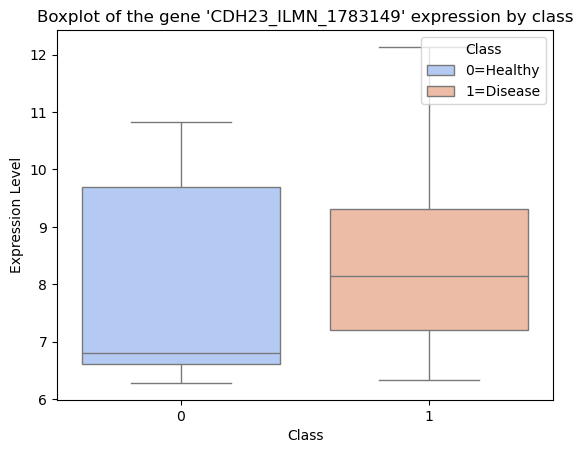

Boxplots below represent the gene: BNIP1_ILMN_2318733; (Data Type: float64)
	Samples for gene BNIP1_ILMN_2318733 - Class 0 (Healthy): 62, Outliers: 0
	Samples for gene BNIP1_ILMN_2318733 - Class 1 (Diseased): 330, Outliers: 3
	Gene BNIP1_ILMN_2318733 - Class 0 (Healthy): Min = 7.435, Median = 8.133, Max = 8.748, Mean = 8.136, Std = 0.291
	Gene BNIP1_ILMN_2318733 - Class 1 (Diseased): Min = 6.734, Median = 7.878, Max = 8.804, Mean = 7.907, Std = 0.275


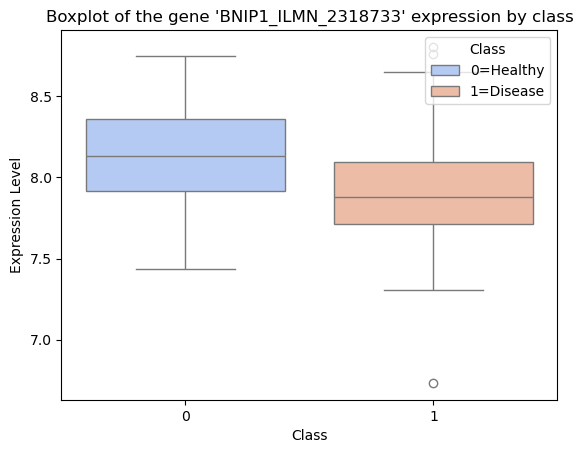

Boxplots below represent the gene: C7_ILMN_1687848; (Data Type: float64)
	Samples for gene C7_ILMN_1687848 - Class 0 (Healthy): 62, Outliers: 0
	Samples for gene C7_ILMN_1687848 - Class 1 (Diseased): 330, Outliers: 0
	Gene C7_ILMN_1687848 - Class 0 (Healthy): Min = 6.057, Median = 6.886, Max = 12.895, Mean = 8.382, Std = 2.468
	Gene C7_ILMN_1687848 - Class 1 (Diseased): Min = 6.026, Median = 10.700, Max = 14.561, Mean = 10.081, Std = 2.184


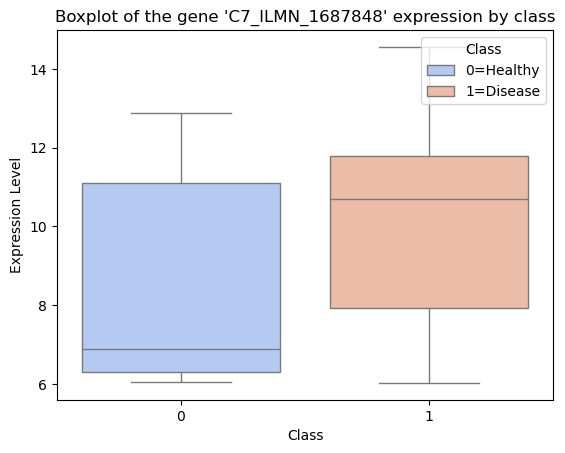

Boxplots below represent the gene: DTX1_ILMN_1689002; (Data Type: float64)
	Samples for gene DTX1_ILMN_1689002 - Class 0 (Healthy): 62, Outliers: 1
	Samples for gene DTX1_ILMN_1689002 - Class 1 (Diseased): 330, Outliers: 4
	Gene DTX1_ILMN_1689002 - Class 0 (Healthy): Min = 7.714, Median = 8.656, Max = 10.351, Mean = 8.737, Std = 0.509
	Gene DTX1_ILMN_1689002 - Class 1 (Diseased): Min = 6.788, Median = 7.959, Max = 10.110, Mean = 8.018, Std = 0.611


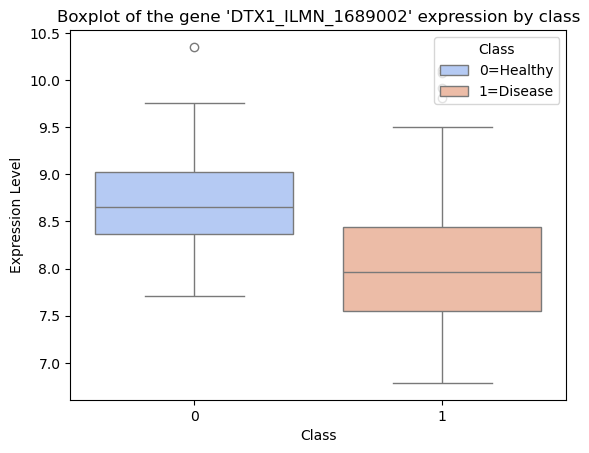

Boxplots below represent the gene: ASPN_ILMN_2168166; (Data Type: float64)
	Samples for gene ASPN_ILMN_2168166 - Class 0 (Healthy): 62, Outliers: 0
	Samples for gene ASPN_ILMN_2168166 - Class 1 (Diseased): 330, Outliers: 4
	Gene ASPN_ILMN_2168166 - Class 0 (Healthy): Min = 6.289, Median = 8.414, Max = 11.277, Mean = 8.564, Std = 1.493
	Gene ASPN_ILMN_2168166 - Class 1 (Diseased): Min = 6.354, Median = 9.916, Max = 12.512, Mean = 9.891, Std = 1.422


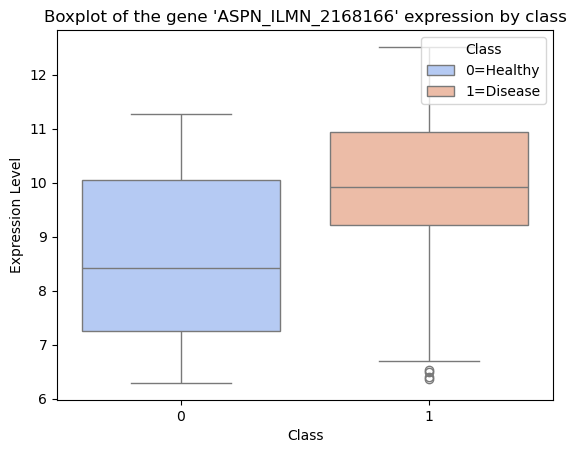

Total outliers across all genes - Class 0 (Healthy): 1, which is 8.333% of the total outliers, but they represent 15.816% of the samples here
Total outliers across all genes - Class 1 (Diseased): 11, which is 91.667% of the total outliers, but they represent 84.184% of the samples here


In [29]:
# mapping disease labels for better legend clarity
transposedDF['disease_label'] = transposedDF['disease'].map({0: '0=Healthy', 1: '1=Disease'})

# counters for total outliers and total samples in each class
total_outliers_class_0 = 0
total_outliers_class_1 = 0
total_samples_class_0 = 0
total_samples_class_1 = 0

# interating over each gene in the top_genes_10
for gene in top_genes_5:
    print(f"Boxplots below represent the gene: {gene}; (Data Type: {transposedDF[gene].dtype})")

    # grouping by class (disease) and calculating Q1, Q3, and IQR
    grouped = transposedDF.groupby('disease')[gene]
    outliers_class_0 = outliers_class_1 = 0
    samples_class_0 = samples_class_1 = 0

    # vars to store min, median, max, mean, and std values for each class
    min_class_0 = median_class_0 = max_class_0 = mean_class_0 = std_class_0 = None
    min_class_1 = median_class_1 = max_class_1 = mean_class_1 = std_class_1 = None

    for label, group in grouped:
        # samples in each class for this gene
        if label == 0:  # class 0: Healthy
            samples_class_0 = len(group)
            total_samples_class_0 += len(group)
            min_class_0 = group.min()
            median_class_0 = group.median()
            max_class_0 = group.max()
            mean_class_0 = group.mean()
            std_class_0 = group.std()
        elif label == 1:  # class 1: Diseased
            samples_class_1 = len(group)
            total_samples_class_1 += len(group)
            min_class_1 = group.min()
            median_class_1 = group.median()
            max_class_1 = group.max()
            mean_class_1 = group.mean()
            std_class_1 = group.std()

        # outliers for this group
        Q1 = group.quantile(0.25)
        Q3 = group.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = group[(group < lower_bound) | (group > upper_bound)]

        # updating outlier counters
        if label == 0:  # class 0: Healthy
            outliers_class_0 = len(outliers)
            total_outliers_class_0 += len(outliers)
        elif label == 1:  # class 1: Diseased
            outliers_class_1 = len(outliers)
            total_outliers_class_1 += len(outliers)

    # number of outliers and samples for each class for this gene
    print(f"\tSamples for gene {gene} - Class 0 (Healthy): {samples_class_0}, Outliers: {outliers_class_0}")
    print(f"\tSamples for gene {gene} - Class 1 (Diseased): {samples_class_1}, Outliers: {outliers_class_1}")

    # min, median, max, mean, and std for each class
    print(f"\tGene {gene} - Class 0 (Healthy): Min = {min_class_0:.3f}, Median = {median_class_0:.3f}, Max = {max_class_0:.3f}, Mean = {mean_class_0:.3f}, Std = {std_class_0:.3f}")
    print(f"\tGene {gene} - Class 1 (Diseased): Min = {min_class_1:.3f}, Median = {median_class_1:.3f}, Max = {max_class_1:.3f}, Mean = {mean_class_1:.3f}, Std = {std_class_1:.3f}")

    # creating the boxplot
    sns.boxplot(x='disease', y=gene, data=transposedDF, hue='disease_label', palette="coolwarm", dodge=False)
    plt.title(f"Boxplot of the gene '{gene}' expression by class")
    plt.xlabel("Class")
    plt.ylabel("Expression Level")
    plt.legend(title="Class", loc="upper right")  # Update legend title
    plt.show()

# printing total outliers and samples across all genes per class
total_outliers_both = total_outliers_class_0 + total_outliers_class_1
total_samples_both = total_samples_class_0 + total_samples_class_1

print(f"Total outliers across all genes - Class 0 (Healthy): {total_outliers_class_0}, which is {(total_outliers_class_0/total_outliers_both)*100:.3f}% of the total outliers, but they represent {(total_samples_class_0/total_samples_both)*100:.3f}% of the samples here")
print(f"Total outliers across all genes - Class 1 (Diseased): {total_outliers_class_1}, which is {(total_outliers_class_1/total_outliers_both)*100:.3f}% of the total outliers, but they represent {(total_samples_class_1/total_samples_both)*100:.3f}% of the samples here")

# Histogram Visualization & Distribution

Informed by the boxplots above, we decided to see what the distribution looks like in terms of peaks for class (0=healthy, 1=disease) across all of the top 5 genes, and found that for many genes, the healthy samples had less extreme values (e.g. see the top 3 most predictive genes, i.e. the first 3 boxplot pairs below) and you might notice that the disease samples have more of a spread, with more values concentrated towards the middle of the range. This is a fascinating finding that has not been widely documentend in the literature, which normally discusses genes being upregulated or downregulated in general. However, what this tells us is that it's possible that healthy women without endometriosis have more robus gene regulation, leading to a more bimodal looking distribution - i.e. their gene is conditionally turned up or down based on their current needs, not just moderately expressed on a consistent basis.

However, I will note that are genes included below which seem to be predictive for other reasons too, e.g the classic idea that certain genes are simply just upregulated or downregulated in general for women with endometriosis.

#### **Takeaway:**

Considering that the top 3 most predictive genes seem to be bimodal in healthy women and more concetrated in the middle for women with the disease, it's possible that an RF may capture and exploit these relationships as aggressively as a boosting model - for that reason, we will be comparing a fine-tuned RF model with an XGBoost model.

Currently, the same simple RF model with just the top 5 genes as predictors (instead of 28k+ genes) achieves an impressively similar `Test Macro F1 Score` of 0.71 compared to the original RF baseline model score of 0.73. This has inspired our research question: **"Can we maintain or improve endometriosis prediction using Random Forest or XGBoost after drastically reducing features from over 28k genes to a small, most-predictive subset - and what does this subset reveal about the disease?"**

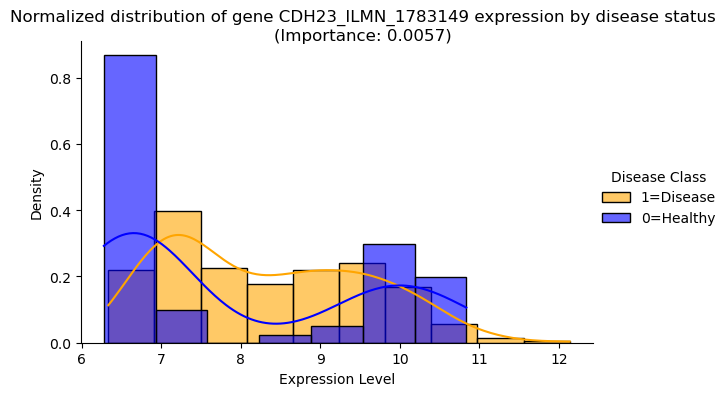

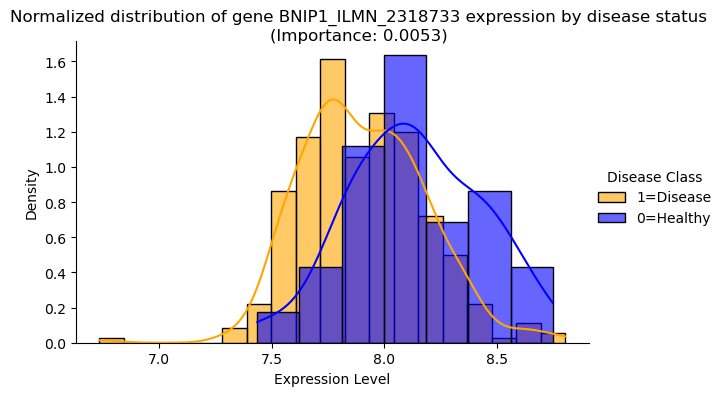

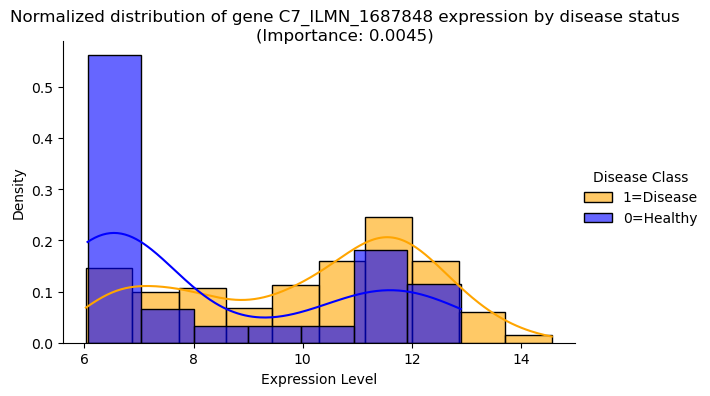

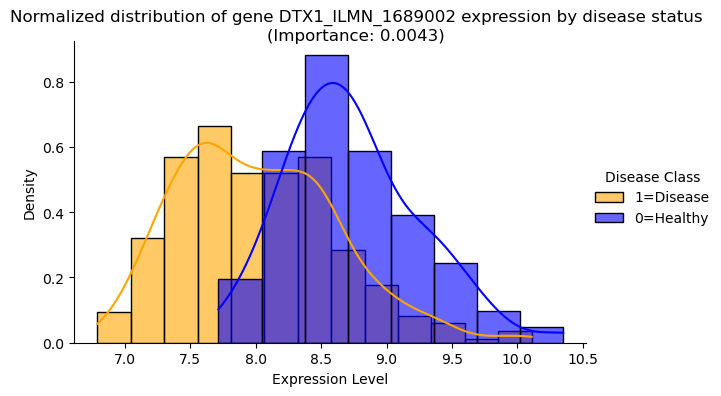

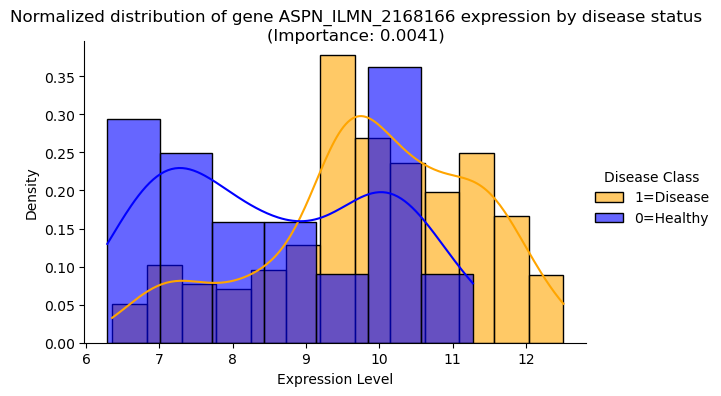

In [30]:
# mapping the disease column to descriptive labels
transposedDF['disease_label'] = transposedDF['disease'].map({0: '0=Healthy', 1: '1=Disease'})

# defining a custom color palette to ensure "Healthy" is blue and "Disease" is orange
custom_palette = {"0=Healthy": "blue", "1=Disease": "orange"}

# iterating over the sorted list of genes and their importance scores
for gene, importance in contribution.items():  # Use the `contribution` dictionary
    g = sns.FacetGrid(transposedDF, hue="disease_label", palette=custom_palette, height=4, aspect=1.5)
    g.map(sns.histplot, gene, kde=True, alpha=0.6, stat="density")  # Using 'density' to normalize
    g.add_legend(title="Disease Class")
    g.set_axis_labels("Expression Level", "Density")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f"Normalized distribution of gene {gene} expression by disease status\n(Importance: {importance:.4f})")
    plt.show()


# Heatmap
The same top 5 genes show complex correlation patterns in the histogram below, with some strongly positively correlated and others moderately negatively correlated. We look forward to seeing how RF compares to XGBoost given the below.

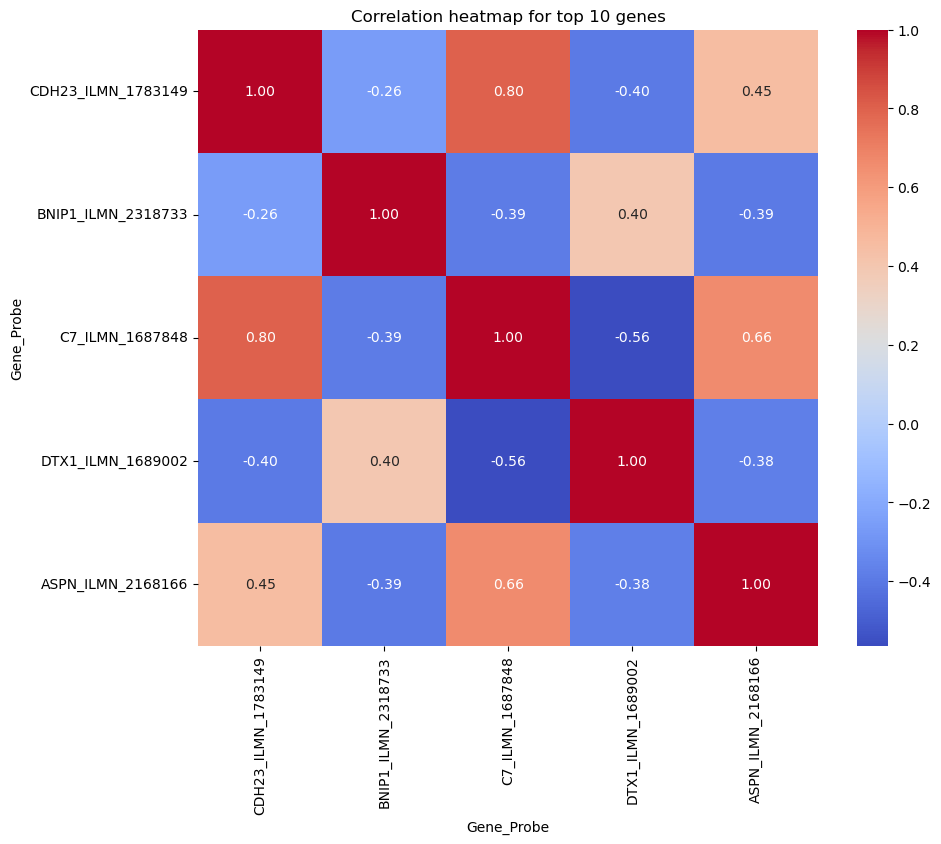

In [31]:
# data for the top 5 genes
top_genes_data = transposedDF[top_genes_5]

# the correlation matrix
correlation_matrix = top_genes_data.corr()

# plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation heatmap for top 10 genes")
plt.show()

# Clustering Plot
The dendrogram shows clustering of these top genes into two main groups, hinting at an underlying biological relationships - potentially in terms of inflammatory and hormonal pathways. These complex, non-linear patterns we have seen in our visulizations so far, coupled with the other data characteristics (imbalanced and highly-dimensional), motivated us to start with the random forest ensemble.

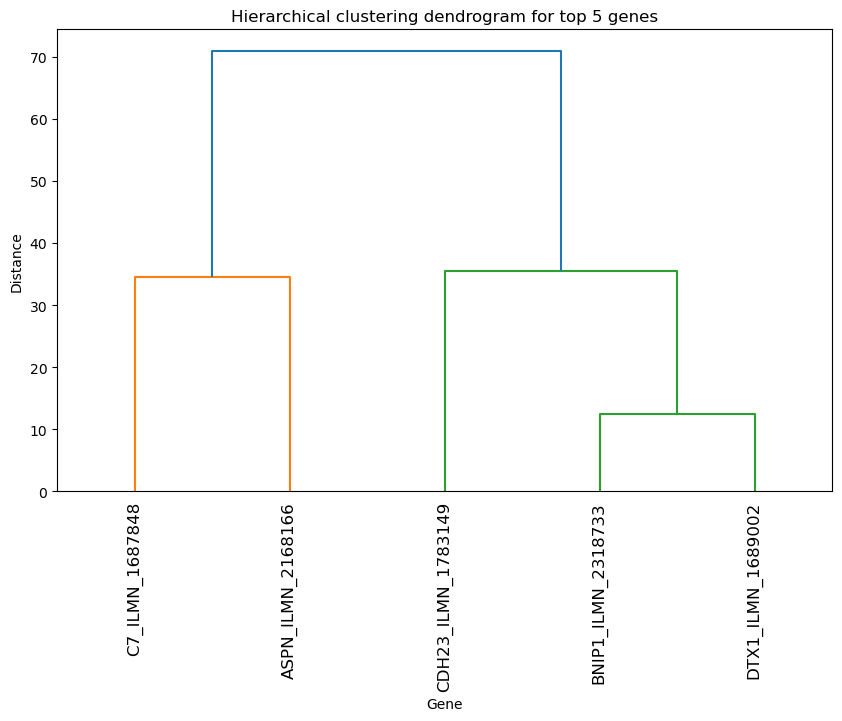

In [32]:
# hierarchical clustering
linkage_matrix = linkage(top_genes_data.T, method="ward")\

# dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=top_genes_5, leaf_rotation=90)
plt.title("Hierarchical clustering dendrogram for top 5 genes")
plt.xlabel("Gene")
plt.ylabel("Distance")
plt.show()


# RFE 1: The best genes (predictors) that were selected by the RF-based RFE process
### Some technical details about RF-based RFE:
We performed recursive feature elimination (RFE) to find the most optimal features to train our canidate models on. We optimized and measured model performance using `f1_macro`, which ensures that the selected features help the models best predict both classes equally as the `f1-macro` score measures a models performance from multiple angles for both classes. Due to the computationally intense nature of this process we parallelized it over all available CPU cores to reduce the processes execution time. Note that the estimator underlying this process is Random Forest and for the next RFE process, we will be repreating this RFE process with XGBoost as the underlying model. If we can gain access to more stable and powerful computer power, we are eager to experiment with different `step` values and `scoring` metrics through CV. That would be possible for us for this first RFE process, it is not feasible for the next RFE process (given the sequential, time-intensive nature of the XGBoost-estimator based RFE). To ensure fair comparability, we decided against fine-tuning this step.

In [33]:
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    step=0.01,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

# fitting RFE on the training set only
rfecv.fit(X_train, y_train)

# getting selected features from the training set
selected_features = X_train.columns[rfecv.support_]

# creating reduced training and test sets based on selected features
X_train_reduced_rf_rfe = X_train[selected_features]
X_test_reduced_rf_rfe = X_test[selected_features]

print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected features:")
print(selected_features.tolist())

Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27401 features.
Fitting estimator with 27401 features.
Fitting estimator with 27401 features.
Fitting estimator with 27401 features.
Fitting estimator with 27401 features.
Fitting estimator with 27119 features.
Fitting estimator with 27119 features.
Fitting estimator with 27119 features.
Fitting estimator with 27119 features.
Fitting estimator with 27119 features.
Fitting estimator with 26

# Random Forest - trained with RFE 1 (predictors identified from RF-based RFE process)
The Random Forest Classifier was trained using features selected by RFE 1 (with a Random Forest Classifier as the underlying model). This model performed the worst overall, as measured by both its `Test Macro F1 Score` of 0.64 and its `Test PC-Recall AUC` of 0.95. This poor performance can likely be attributed to lack of fine-tuning of certain parameters during the RFE process. As we will see momentarily, the RFE process using XGBoost as the estimator, did a better job - this is likely attributable to Random Forest tendency to rank correlated features equally and favors broader feature selection, leading to over-pruning, while XGBoost's gradient-boosting nature more precisely identifies and exploits subtle and non-linear relationships, thereby preserving a larger set of relevant features. This fine-tuned RF model had a particularly difficult time identifying healthy samples (the minority class). This model's `Test Macro F1 Score` was low (0.64), with an an even lower `Minority Class (0) F1 Score` of only 0.33. This represents a descreased utility compared to the baseline model. Again, this underperformance is likely due to the class imbalance in the original dataset, in addition to the nature of Random Forest. Even though we used SMOTE to resample the data before training, Random Forest Classifiers lack the ability to handle class imbalance as effectively as gradient boosting methods like XGBoost, as we will show in later sections.

### Some technical details about this model using RF-based RFE-derived predictors:
We trained a Random Forest Classifier using the selected features derived from performing RFE 1 with a Random Forest estimator. We resampled our data using SMOTE, and used GridSearchCV to fine-tune the hyperparameters of this model, optimizing parameters like the number of estimators, maximum depth, and minimum samples for splitting and leaf composition. We then adjusted our predictions by setting a threshold that optimizes for the F1-score of the  class "1" (disease samples). We then scored the adjusted predictions using a classification report and its calculated precision-recall AUC.

#### Custom Scorer Function
Since our baseline model revealed a discrepancy in F1-scores between the healthy and sick classes, we implemented a custom scorer to prioritize improving the performance of the minority class (class 0, healthy patients). The goal is for this approach to help boost the macro F1-score for all models, improving their overall balance and effectiveness. GridSearchCV used this custom scorer to determine the optimal hyperparameters combination. We will use this custom scorer when fine-tuning our hyper parameters for all the following candidate models.

In [34]:
def f1_class_0(y_true, y_pred):
    return f1_score(y_true, y_pred, pos_label=0)

custom_scorer = make_scorer(f1_class_0, greater_is_better=True)

In [35]:
# we already have X_train_reduced_rf_rfe and X_test_reduced_rf_rfe from RFE step
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reduced_rf_rfe, y_train)

# Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight="balanced")

# setting up parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 150],  # Number of trees in the forest
    "max_depth": [None, 10, 20],     # Maximum depth of each tree
    "min_samples_split": [2, 5, 10], # Minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 4],   # Minimum number of samples required to be at a leaf node
}

# performing GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3,
    n_jobs=-1
)

# fitting the grid search model
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predictions on TRAIN set (before threshold adjustment, we just measure model performance on training data)
y_pred_train_resampled = best_model.predict(X_train_resampled)
y_pred_proba_train_resampled = best_model.predict_proba(X_train_resampled)[:, 1]

# Make predictions for the TEST set
probs = best_model.predict_proba(X_test_reduced_rf_rfe)[:, 1]  # probabilities for the positive class

# optimal threshold using the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.2f}")

# Adjust predictions based on the optimal threshold
y_pred_adjusted = (probs >= optimal_threshold).astype(int)

# Evaluate the adjusted predictions
print("\nConfusion Matrix with Adjusted Threshold:")
print(confusion_matrix(y_test, y_pred_adjusted))

print("\nClassification Report with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

# Calculate PR AUC and Macro F1 for TRAIN set
train_pr_auc = average_precision_score(y_train_resampled, y_pred_proba_train_resampled)
train_macro_f1 = f1_score(y_train_resampled, y_pred_train_resampled, average='macro')

# Calculate PR AUC and Macro F1 for TEST set (using adjusted predictions and original probabilities)
test_pr_auc = average_precision_score(y_test, probs)
test_macro_f1 = f1_score(y_test, y_pred_adjusted, average='macro')

# Print training metrics
print("=== Training Set Metrics (RFE 1) ===")
print(classification_report(y_train_resampled, y_pred_train_resampled))
print(f"Training Precision-Recall AUC: {train_pr_auc:.2f}")
print(f"Training Macro F1 Score: {train_macro_f1:.2f}")

# Print test metrics
print("\n=== Test Set Metrics (RFE 1) ===")
print(classification_report(y_test, y_pred_adjusted))
print(f"Test Precision-Recall AUC: {test_pr_auc:.2f}")
print(f"Test Macro F1 Score: {test_macro_f1:.2f}")

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Optimal threshold: 0.01

Confusion Matrix with Adjusted Threshold:
[[ 2  7]
 [ 1 69]]

Classification Report with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.67      0.22      0.33         9
           1       0.91      0.99      0.95        70

    accuracy                           0.90        79
   macro avg       0.79      0.60      0.64        79
weighted avg       0.88      0.90      0.88        79

=== Training Set Metrics (RFE 1) ===
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       260
           1       0.94      0.89      0.91       260

    accuracy                           0.91       520
   macro avg       0.91      0.91      0.91       520
weighted avg       0.91      0.91      0.91       520

Training Precision-Recall AUC: 0.98
Training Macro F1 Score: 0.91

==

# RFE 2: The best genes (predictors) that were selected by the XGBoost-based RFE process
We learned that XGBoost can be helpful for highly-dimensional and imbalanced dataset, and that their added complexity can be justified when RF models aren't sufficiently powerful, as in our previous case. XGBoost is helpful because it can "learn from its mistakes" during the iterative process of making the next tree.

### Some technical details about XGBoost-based RFE:
We followed a very similar process as before except we replaced the underlying estimator, `RandomForestClassifier` with a `XGBoostClassifier` and had a slighlty larger `cv` score. These changed led to an increase in the processing time of the below code, compared to the previous RFE code with RF as the estimator. In this final milestone, we tried hyperparameter tuning for the `step` part of both RFE1 (RF-based), but found that fine-tuning this hyper parameter did not have the desired effect of improving our objective metric - for simplicity, we have removed that.

In [36]:
rfecv = RFECV(
    estimator=XGBClassifier(random_state=42, n_jobs=-1), # XGBoost
    step=0.01, # smaller step size for finer selection
    cv=7, # cross-validation folds for robust results
    scoring="f1_macro", # scoring metric
    n_jobs=-1, # parallelism for RFECV itself
    verbose=1 # output progress to monitor
)

# fitting RFECV to the train data
rfecv.fit(X_train, y_train)

selected_features = X_train.columns[rfecv.support_]
X_train_reduced_xgb_rfe = X_train[selected_features]
X_test_reduced_xgb_rfe = X_test[selected_features]

print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected features:")
print(selected_features.tolist())

Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 28247 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27965 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27401 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27683 features.
Fitting estimator with 27401 features.
Fitting estimator with 27119 features.
Fitting estimator with 27401 features.
Fitting estimator with 27

# XGBoost - trained with RFE 2 (predictors identified from XGBoost-based RFE process)
The XGBoost Classifier trained using features selected by RFE with XGBoost as the estimator performed significantly better at predicting the minority classes than the Random Forest Classifier trained using features selected by the previous RFE process. The `Minority Class (0) F1 Score` increased to 0.67, beating the other models' performance in terms of this metric. Finetuning this XGBoost model was done in a similar manner as the previous RF model, though we made sure to fine-tune subsample ratio of training instances and the ratio of columns for each tree in this case. Given that our overall objective is to contribute to our understanding differences in gene expression between endometriosis and healthy samples, this use case justifies the computational intensity of a lower `step` value during RFE 2. Additionally, it should be noted that the `Test Macro F1 Score` for this model increased to 0.80 to from 0.73 with the baseline RF model, despite us reducing the number of features significantly - from 28k+ to 329. This tells us that our dataset is very noisy, and it is important to capture the most relevant features, necessitating a very rigorious cross validation process. With access to more compute power, we belive that we could further reduce the number of feature further, reducing even more noise while increasing the `Test Macro F1 Score` metric.

### Some technical details about this model also using XGBoost-based RFE-derived predictors:
We follow a very similar methodology as the Random Forest model training, with the important exception that we are using predictors from the XGBoost estimator-based RFE 2 process. As noted above, we also fine-tune subsample ratio of training instances and the ratio of columns for each tree in this case.

In [37]:
# XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric="logloss")  # 'logloss' avoids issues with probability predictions

# Parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 150],   # Number of boosting rounds
    "max_depth": [2, 3, 5, 7],        # Max depth of a tree
    "learning_rate": [0.01, 0.1, 0.2],# Learning rate
    "subsample": [0.8, 1.0],          # Subsample ratio of training instances
    "colsample_bytree": [0.8, 1.0],   # Subsample ratio of columns for each tree
}

# Apply SMOTE on the RFE 2 reduced training set
smote = SMOTE(random_state=42)
X_train_resampled_xgb_rfe, y_train_resampled_xgb_rfe = smote.fit_resample(X_train_reduced_xgb_rfe, y_train)

# GridSearchCV to find the best hyperparameters using the custom scorer
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=custom_scorer,  # custom f1_class_0 scorer
    cv=7,
    n_jobs=-1
)

# Fit the grid search model on the RFE 2 resampled training data
grid_search.fit(X_train_resampled_xgb_rfe, y_train_resampled_xgb_rfe)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predictions and probabilities on the TRAIN set (RFE 2)
y_pred_train = best_model.predict(X_train_resampled_xgb_rfe)
y_pred_proba_train = best_model.predict_proba(X_train_resampled_xgb_rfe)[:, 1]

# Predictions and probabilities on the TEST set (RFE 2)
probs = best_model.predict_proba(X_test_reduced_xgb_rfe)[:, 1]

# Find the optimal threshold using precision-recall curve on the TEST set
precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold:.2f}")

# Adjust predictions based on the optimal threshold
y_pred_adjusted = (probs >= optimal_threshold).astype(int)

# Calculate metrics for TRAIN set
train_pr_auc = average_precision_score(y_train_resampled_xgb_rfe, y_pred_proba_train)
train_macro_f1 = f1_score(y_train_resampled_xgb_rfe, y_pred_train, average='macro')

# Print training metrics
print("=== Training Set Metrics (XGBoost RFE 2) ===")
print(classification_report(y_train_resampled_xgb_rfe, y_pred_train))
print(f"Training Precision-Recall AUC: {train_pr_auc:.2f}")
print(f"Training Macro F1 Score: {train_macro_f1:.2f}")

# Calculate metrics for TEST set
test_pr_auc = average_precision_score(y_test, probs)
test_macro_f1 = f1_score(y_test, y_pred_adjusted, average='macro')

# Print test metrics
print("\n=== Test Set Metrics (XGBoost RFE 2) ===")
print(classification_report(y_test, y_pred_adjusted))
print(f"Test Precision-Recall AUC: {test_pr_auc:.2f}")
print(f"Test Macro F1 Score: {test_macro_f1:.2f}")

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Optimal threshold: 0.62
=== Training Set Metrics (XGBoost RFE 2) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       260

    accuracy                           1.00       520
   macro avg       1.00      1.00      1.00       520
weighted avg       1.00      1.00      1.00       520

Training Precision-Recall AUC: 1.00
Training Macro F1 Score: 1.00

=== Test Set Metrics (XGBoost RFE 2) ===
              precision    recall  f1-score   support

           0       0.53      0.89      0.67         9
           1       0.98      0.90      0.94        70

    accuracy                           0.90        79
   macro avg       0.76      0.89      0.80        79
weighted avg       0.93      0.90      0.91        79

Test Precision-Recall AUC: 0.99
Test Macro F1 Sco

# Inference

### Getting a ranked list `sorted_importances` of feature importances for this `best_model`
Here, we create a ranked list of the "most important genes" derived from the XGBoost model (variable name: `best_model`).

In [38]:
# getting feature importances from this model
feature_importances = best_model.feature_importances_

# mapping feature importances to feature names
importance_dict = {
    feature: importance for feature, importance in zip(X_train_reduced_xgb_rfe.columns, feature_importances)
}

# sorting features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# printing only the top 20 features
print("\n=== Top 25 Feature Importances ===")
for feature, importance in sorted_importances[:25]:
    print(f"{feature}: {importance:.4f}")

# Creating a list of features from most to least important for this model
ranked_feature_names = [feature for feature, importance in sorted_importances]


=== Top 20 Feature Importances ===
ITGB1BP2_ILMN_1671871: 0.0673
TPK1_ILMN_1804629: 0.0596
SCG2_ILMN_1703178: 0.0584
WDR92_ILMN_1662065: 0.0535
COL16A1_ILMN_1684554: 0.0524
CD40_ILMN_1779257: 0.0363
GASK1B_ILMN_1761941: 0.0347
FUT9_ILMN_1878007: 0.0301
HSPA13_ILMN_2231985: 0.0272
RTL5_ILMN_1757537: 0.0247
HSP90AA1_ILMN_1691097: 0.0245
CD200R1_ILMN_2408112: 0.0234
IFIH1_ILMN_1781373: 0.0233
RHOV_ILMN_1698484: 0.0230
RUSC1_ILMN_1743747: 0.0223
FAM222B_ILMN_1812441: 0.0223
PKN1_ILMN_1662687: 0.0220
DMP1_ILMN_2300022: 0.0204
KMO_ILMN_1730917: 0.0201
NFYB_ILMN_1668726: 0.0175


### Printing overlaid histograms for the top 25 most important genes for this model
Here, we generate (normalized) histograms showing differences in gene expression levels for the top 25 genes, as indicated by the latest iteration of model training with XGBoost following RFE. 

- Visualizing our top predictors below revealed mostly familiar genes, but we were pleasantly surprised to see TPK1 (2nd histogram from the top), as it’s not really cited as an endometriosis biomarker in prevailing medical literature. TPK1 encodes an enzyme that plays a big role in mitochondrial metabolism - a pathway likely disrupted by endometriosis-associated inflammation and signals. In our study, it stands out as our 2nd most predictive gene!
- Healthy samples (in blue) show a bimodal TPK1 expression pattern, suggesting flexible, context-dependent regulation. In contrast, endometriosis samples (in orange) display a more continuous, consistently elevated expression, indicating a “locked-in” metabolic state. This could be driven by chronic inflammation or disrupted feedback loops, potentially giving endometriosis cells a persistent growth and survival advantage.
- While some genes differentiate the 2 classes on the basis of differences in terms of upregulated or downregulated patterns, we DO see the bimodal pattern with several others top genes too, highlighting an underappreciated area in the current medical literature. Endometriosis papers usually talk about predictive genes simply being upregulated or downregulated overall, but with our method (which produces non-linear decision boundaries), we are seeing a more nuanced story unfold, suggesting an area for further research.

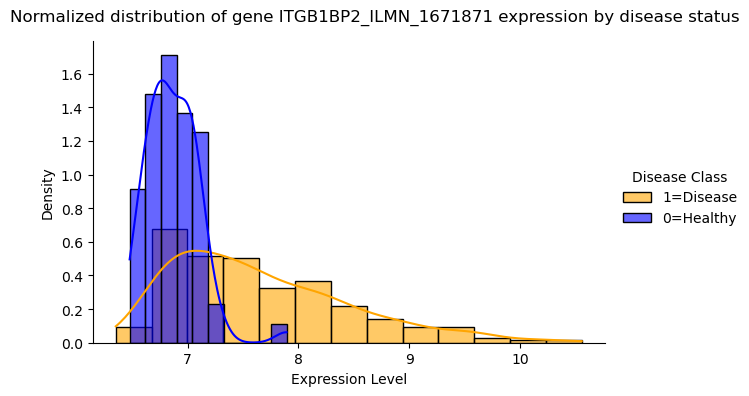

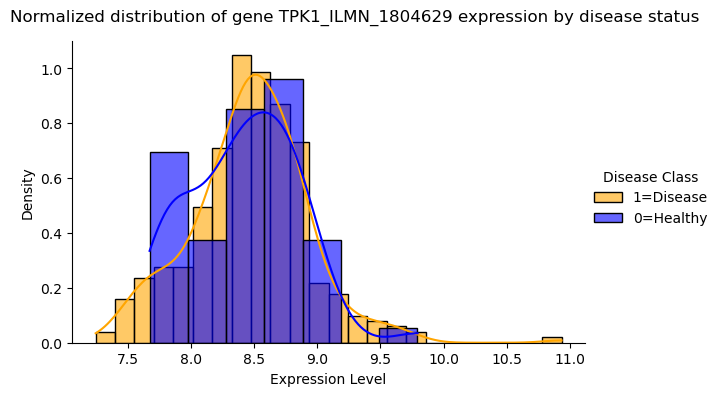

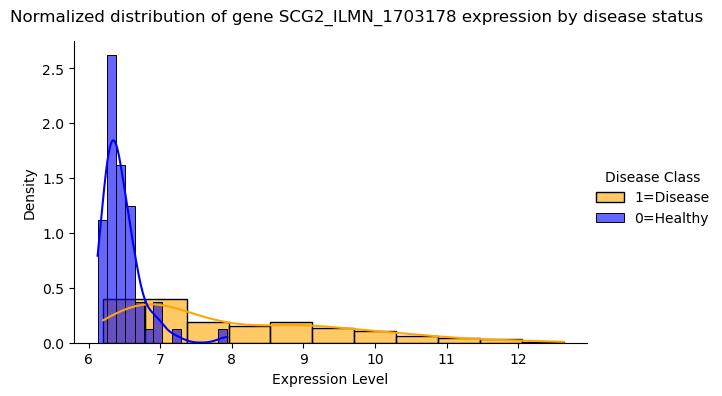

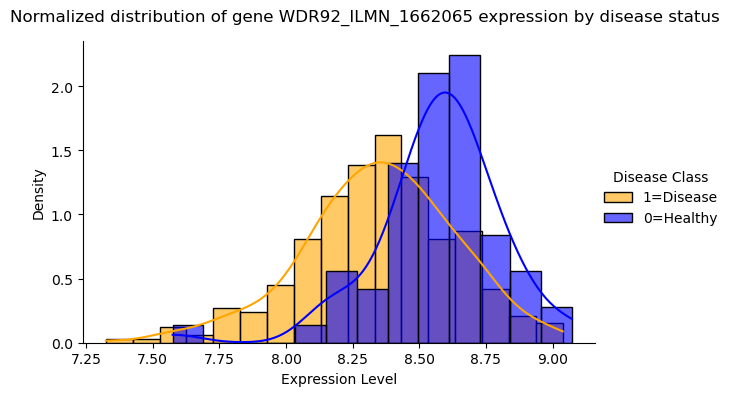

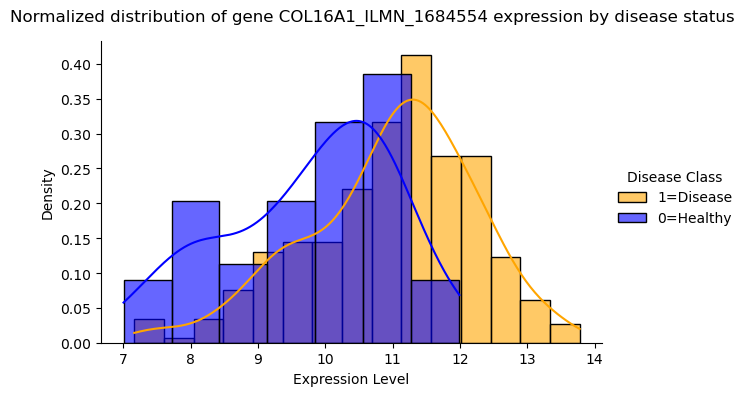

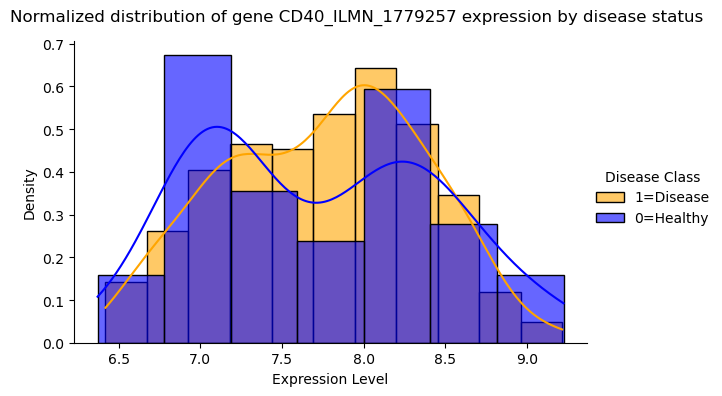

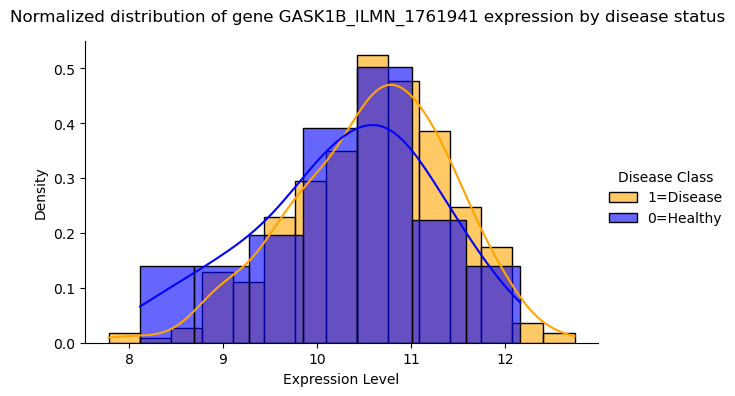

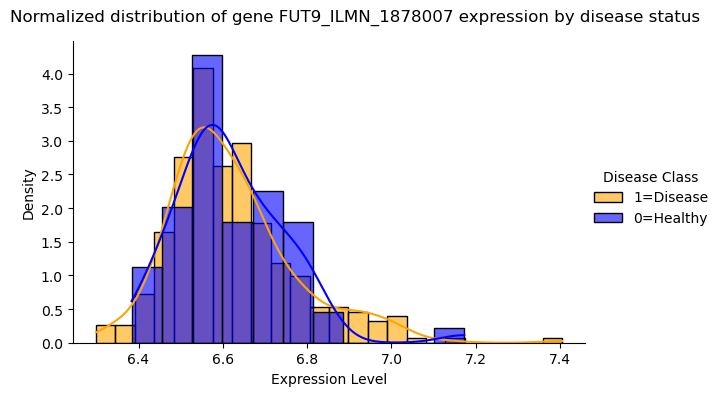

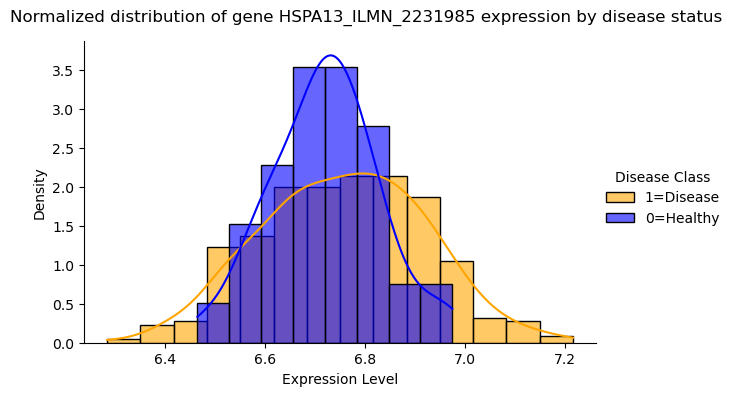

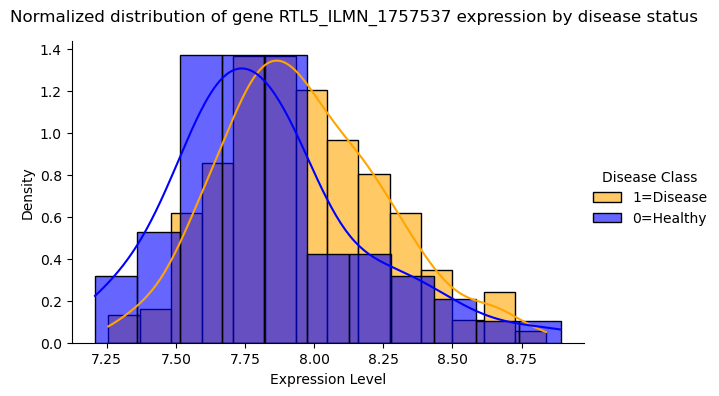

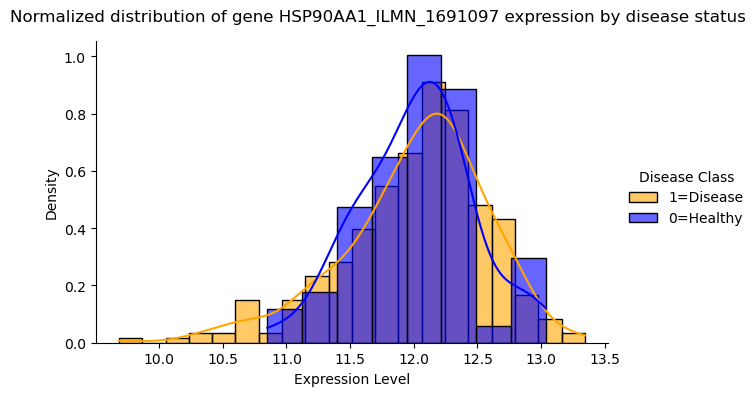

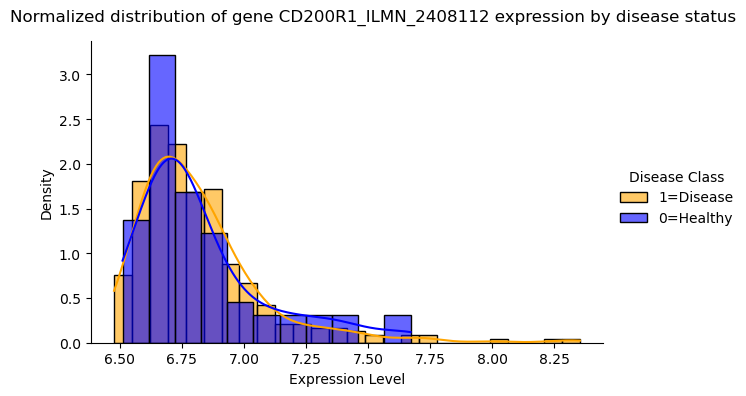

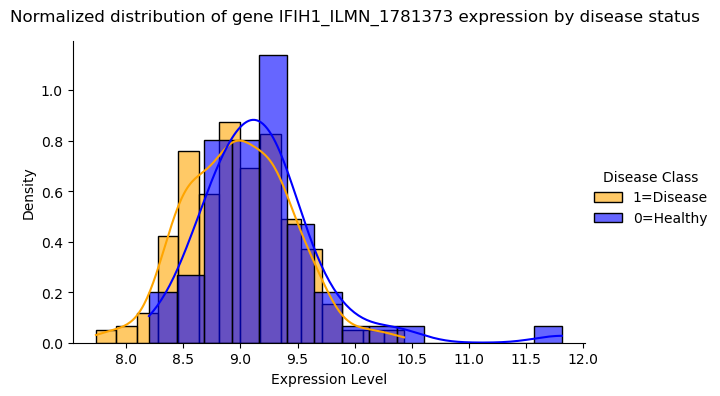

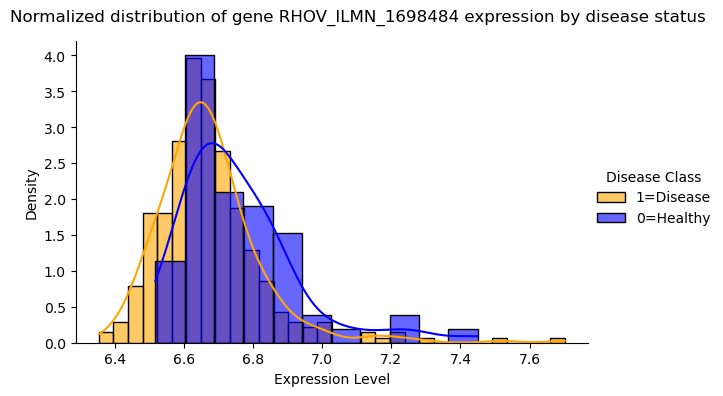

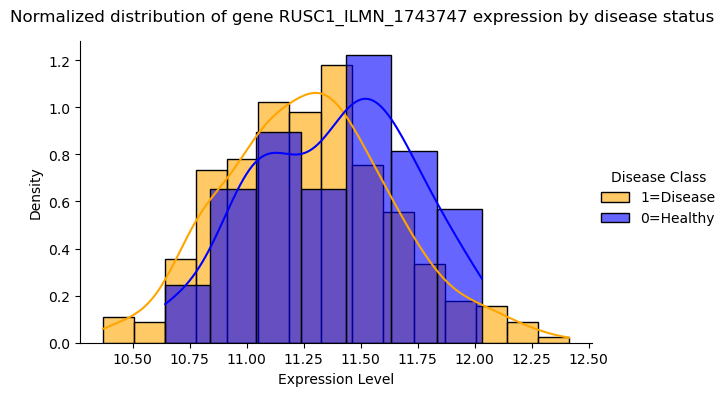

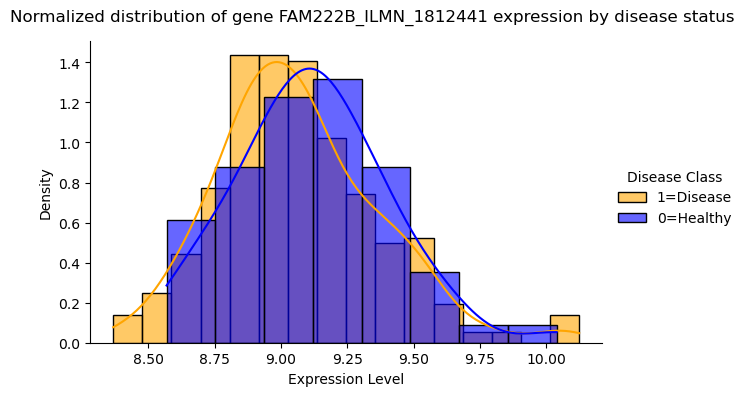

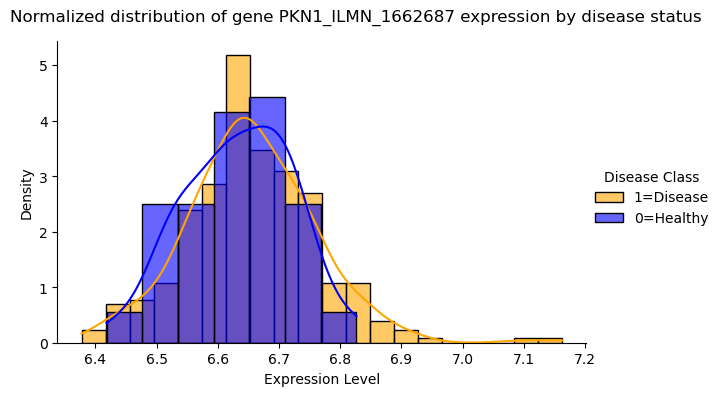

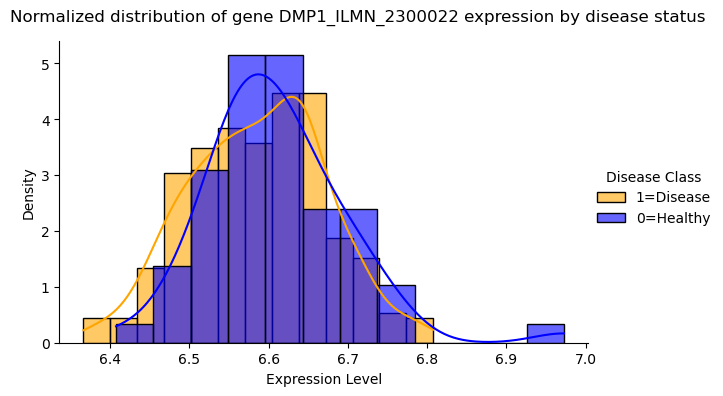

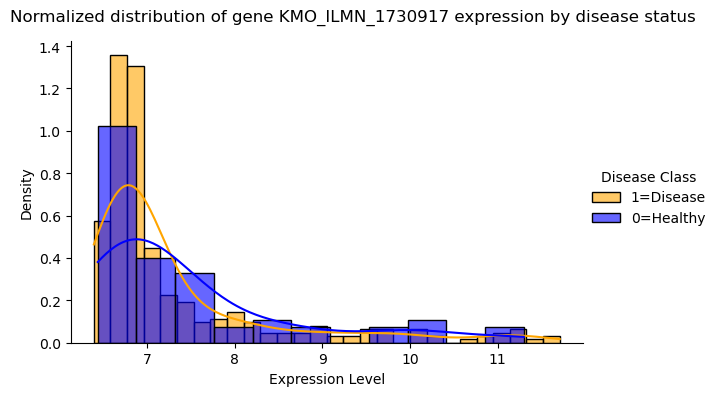

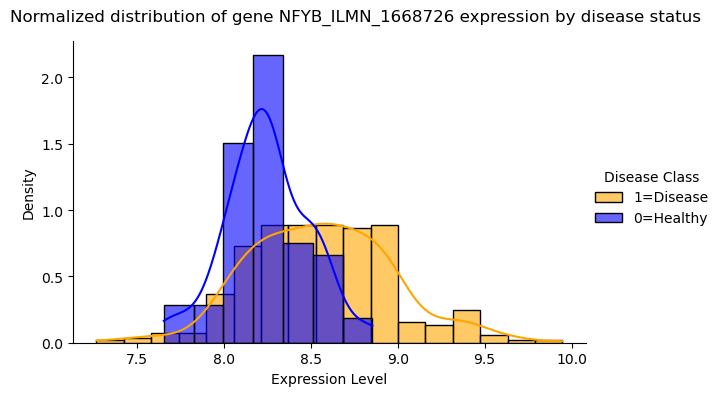

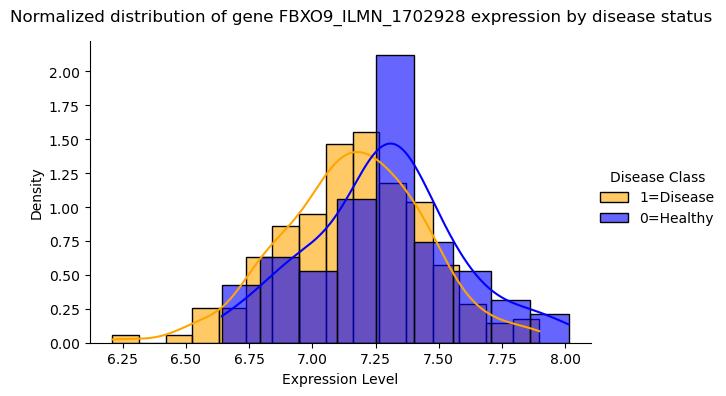

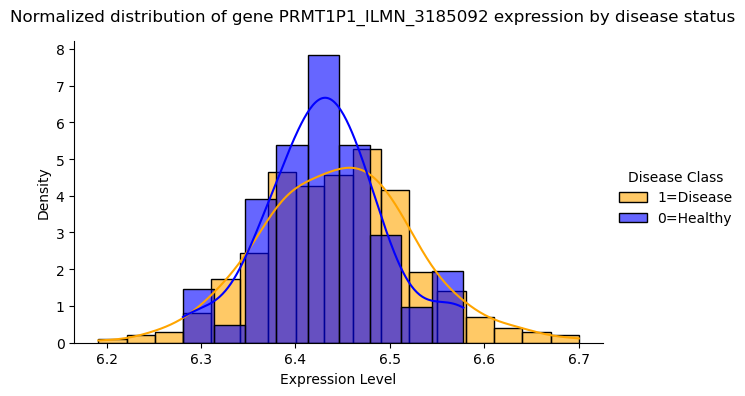

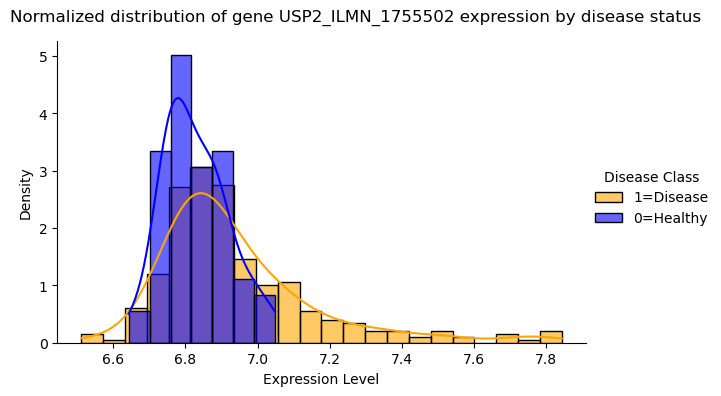

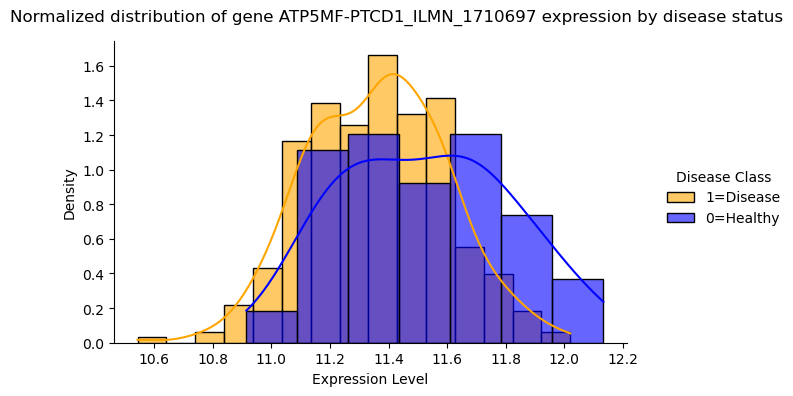

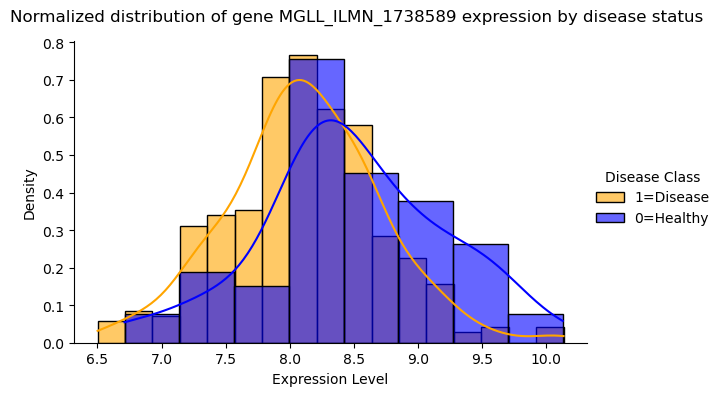

In [39]:
# 1. genes identified by the XGBoost-model based RFE process:
genes_to_plot = ranked_feature_names[:25]

# Mapping the disease column to descriptive labels
transposedDF['disease_label'] = transposedDF['disease'].map({0: '0=Healthy', 1: '1=Disease'})

# Custom color palette
custom_palette = {"0=Healthy": "blue", "1=Disease": "orange"}

# Iterating over the list of genes to plot histograms
for gene in genes_to_plot:
    g = sns.FacetGrid(transposedDF, hue="disease_label", palette=custom_palette, height=4, aspect=1.5)
    g.map(sns.histplot, gene, kde=True, alpha=0.6, stat="density")  # Normalized histograms
    g.add_legend(title="Disease Class")
    g.set_axis_labels("Expression Level", "Density")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f"Normalized distribution of gene {gene} expression by disease status")
    plt.show()

### Dendogram of the top 25 genes identified
Generating a dendogram using the top 25 genes from our final analysis revealed a clustering into 3 major groups. For next steps, it would be very valuable to determine the precise biological reasons for this clustering. However, this visualization is in line with the prevalent thinking that it a relativelt small number of mechanisms (immunological, endochrine, structural) drive this disease. As with many other conditions, the number of genes that contribute to changes in these mechnisms is massive and challenging to detangle.

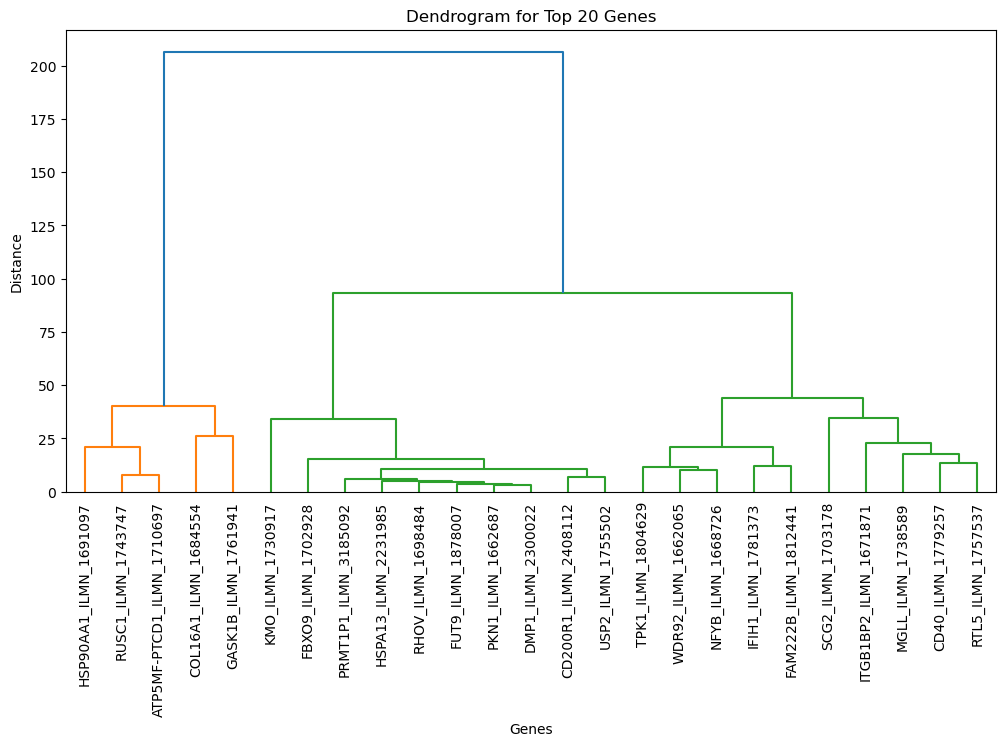

In [40]:
# Extracting data for the top 20 genes
top_genes_data = transposedDF[genes_to_plot]

# Performing hierarchical clustering using the 'ward' method
linked = linkage(top_genes_data.T, method='ward')

# Plotting the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    labels=genes_to_plot,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title("Dendrogram for Top 20 Genes")
plt.xlabel("Genes")
plt.ylabel("Distance")
plt.show()